Base repo of data: https://github.com/mlsedigital/SPL-open-data

Great xyz data dict: https://www.inpredictable.com/2021/01/nba-player-shooting-motions-data-dump.html


## Ultimate Goals:
* Find optimal shooting form/release point
  * Include the feedback system based on optimal shooting form and release point
  * ### Use shooting meter from NBA 2k to show good vs bad releases and body movements
  * ^use the motions that:
    * produce good results (a make or enough kinetic energy for a near make)
    * are within certain boundaries where the player is comfortable AND in right shooting form
    * are within certain ranges (this inch to this inch is the best motion area for this player, etc.)
    * Compared to Popular Shooters to make recommendations to shoot more like someone like Klay Thompson or Buddy Hield (see if the data from the xyz data dictionary has good shooters to make recommendations to shoot like them)
* Exhaustion levels and optimal energy max and min
* Shot outcome prediction


1. Finding Optimal Shooting Form/Release Point

    Detailed Analysis of Body Movements: Include analysis of body kinematics (positions and velocities of limbs) at the time of release. Use joint coordinates to extract features like elbow angle, shoulder rotation, and wrist flexion at the release frame.
    Machine Learning for Form Classification: Train a model to classify "good" vs. "bad" shooting forms using successful shot data (makes or near-makes) and compare them against unsuccessful shots.
    Feedback Mechanism: Implement a feedback system that suggests adjustments based on the comparison of current shooting mechanics to historical optimal ones.

2. Shooting Meter Simulation (NBA 2K-Style)

    Visual Feedback System: Develop a visualization tool that overlays a “meter” on shot video frames, indicating the quality of the release in real-time. This can be based on a scoring function derived from the shooting form features and ball dynamics.
    Comfort Zone Identification: Use clustering algorithms (e.g., K-means) to identify comfortable ranges of motion based on historical shooting data for individual players.

3. Shot Outcome Prediction

    Feature Engineering for Outcome Modeling: Include additional features such as:
        Kinetic Energy Calculation: KE=12mv2KE=21​mv2 to see if the ball had sufficient energy for a make.
        Entry Angle and Trajectory Analysis: Analyze whether the angle at which the ball approaches the hoop aligns with optimal scoring trajectories.
    Model Development: Build a machine learning model (e.g., logistic regression, XGBoost) that predicts shot outcomes based on ball speed, entry angle, release point, and body dynamics.
    Training with Data Augmentation: Use synthetic data generation to include a wide variety of shot scenarios.

4. Exhaustion Levels and Energy Management

    Tracking Player Movements: Use the coordinates of major joints (e.g., knees, hips) to estimate a player's exertion level using metrics like the average vertical displacement over time.
    Velocity and Acceleration Patterns: Monitor changes in the velocity and acceleration of the player's body parts throughout a game to detect fatigue.
    Feature Integration: Create features such as average speed and distance covered leading up to the shot to include in the predictive model.

5. shot simulator: 
    if by these metrics we can simulate the shot to a nearby hoop. We can set the hoop in a set location (or when using spatial, we'd pick the location), and set it up to virtualize the experience with yolo/opencv where when you make those motions to show shooting motion, you can show where the ball might go (even without a ball in hand).

# ML Dataset Pipeline:
    - categorize data
    - multicollinearity/feature importances = feature selection
    - preprocessing suggestions, datasets, preprocessing with strict guidelines
    - ml model selection
    - ml model testing
    - ml data inverse transform
    - ml model prediction
    - live prediction and re-calculate the dataset formulas for when new data attaches
    - get optimal ranges for the angles (knee/wrist/elbow) and input them into the meters
    - input the meters into a video for optimal angles
    - add in ml classification with re-calculation
    - live camera feed with this? 
      - streamlit example of how this works with li


In [1]:
# %%writefile ml/feature_selection/multicollinearity_checker.py

import pandas as pd
import numpy as np

def check_multicollinearity(df, threshold=0.8, debug=False):
    """
    Identifies pairs of features with correlation above the specified threshold.
    Args:
        df (DataFrame): DataFrame containing numerical features.
        threshold (float): Correlation coefficient threshold.
        debug (bool): If True, prints debugging information.
    Returns:
        DataFrame: Pairs of features with high correlation.
    """
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if debug:
        print(f"Computing correlation matrix for {len(numeric_df.columns)} numerical features...")

    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify highly correlated features
    highly_correlated = [
        (column, idx, upper.loc[column, idx])
        for column in upper.columns
        for idx in upper.index
        if (upper.loc[column, idx] > threshold)
    ]

    multicollinearity_df = pd.DataFrame(highly_correlated, columns=['Feature1', 'Feature2', 'Correlation'])

    if debug:
        if not multicollinearity_df.empty:
            print(f"Found {len(multicollinearity_df)} pairs of highly correlated features:")
            print(multicollinearity_df)
        else:
            print("No highly correlated feature pairs found.")

    return multicollinearity_df



if __name__ == "__main__":
    import pickle
    # Load the category bin configuration
    with open('../../data/model/pipeline/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)
    
    # Feature selection based on multi collinearity and random forest importance selection
    target_variable = 'result'
    correlation_threshold = 0.8
    debug = True

    # Remove columns to address collinearity
    drop_features = [ 'L_KNEE_min_power', 'L_HIP_max_power']
    
    # Step 1: Check for multicollinearity
    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    # Step 2: Handle multicollinearity
    if not multicollinearity_df.empty:
        for index, row in multicollinearity_df.iterrows():
            feature1, feature2, correlation = row['Feature1'], row['Feature2'], row['Correlation']
            print(f"High correlation ({correlation}) between '{feature1}' and '{feature2}'.")
    else:
        print("No multicollinearity issues detected.")



Checking for Multicollinearity...
Computing correlation matrix for 132 numerical features...
Found 431 pairs of highly correlated features:
                   Feature1                Feature2  Correlation
0         L_ANKLE_max_power       L_ANKLE_std_power     0.925380
1         R_ANKLE_max_power       R_ANKLE_std_power     0.909245
2          L_KNEE_max_power        R_KNEE_max_power     0.858762
3          L_KNEE_avg_power        R_KNEE_avg_power     0.918763
4          L_KNEE_avg_power         L_HIP_avg_power     0.804101
..                      ...                     ...          ...
426  L_1STFINGER_energy_std  L_5THFINGER_energy_std     0.989249
427  L_1STFINGER_energy_std  R_5THFINGER_energy_std     0.962547
428  R_1STFINGER_energy_std  L_5THFINGER_energy_std     0.934655
429  R_1STFINGER_energy_std  R_5THFINGER_energy_std     0.995210
430  L_5THFINGER_energy_std  R_5THFINGER_energy_std     0.939738

[431 rows x 3 columns]
High correlation (0.9253798811958034) between 'L_ANKLE_

In [2]:
# %%writefile ml/feature_selection/feature_importance_calculator.py

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import logging
import pandas as pd
import pickle
from typing import Optional, List, Dict, Any, Tuple
import numpy as np

def calculate_feature_importance(df, target_variable, n_estimators=100, random_state=42, debug=False):
    """
    Calculates feature importance using a Random Forest model.
    Args:
        df (DataFrame): Input DataFrame.
        target_variable (str): Target column name.
        n_estimators (int): Number of trees in the forest.
        random_state (int): Random seed.
        debug (bool): If True, prints debugging information.
    Returns:
        DataFrame: Feature importances.
    """
    X = df.drop(columns=[target_variable])
    y = df[target_variable]

    # Encode target variable if necessary
    if y.dtype == 'object' or str(y.dtype) == 'category':
        if debug:
            print(f"Target variable '{target_variable}' is categorical. Encoding labels.")
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Separate categorical and numerical features
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

    if debug:
        print(f"Categorical columns: {categorical_cols}")
        print(f"Numerical columns: {numeric_cols}")

    # Encode categorical features if present
    if categorical_cols:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        X_encoded = ohe.fit_transform(X[categorical_cols])
        X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=X.index)
        X = pd.concat([X[numeric_cols], X_encoded_df], axis=1)

    # Select model
    model = (
        RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
        if y.dtype in ['int64', 'float64'] else
        RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    )

    if debug:
        print(f"Training Random Forest model with {n_estimators} estimators...")

    model.fit(X, y)

    # Calculate feature importances
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    if debug:
        print("Feature Importances:")
        print(feature_importances)

    return feature_importances


def manage_features(
    mode: str,
    features_df: Optional[pd.DataFrame] = None,
    ordinal_categoricals: Optional[List[str]] = None,
    nominal_categoricals: Optional[List[str]] = None,
    numericals: Optional[List[str]] = None,
    y_variable: Optional[str] = None,
    paths: Optional[Dict[str, str]] = None
) -> Optional[Dict[str, Any]]:
    """
    Save or load features and metadata.

    Parameters:
        mode (str): Operation mode - 'save' or 'load'.
        features_df (pd.DataFrame, optional): DataFrame containing features to save (required for 'save').
        ordinal_categoricals (list, optional): List of ordinal categorical features.
        nominal_categoricals (list, optional): List of nominal categorical features.
        numericals (list, optional): List of numerical features.
        y_variable (str, optional): Target variable.
        paths (dict, optional): Dictionary mapping each item to its file path.

    Returns:
        If mode is 'load', returns a dictionary with loaded items.
        If mode is 'save', returns None.
    """

    # Define default paths if not provided
    default_paths = {
        'features': 'final_ml_df_selected_features_columns_test.pkl',
        'ordinal_categoricals': 'ordinal_categoricals.pkl',
        'nominal_categoricals': 'nominal_categoricals.pkl',
        'numericals': 'numericals.pkl',
        'y_variable': 'y_variable.pkl'
    }

    # Update default paths with any provided paths
    if paths:
        default_paths.update(paths)

    try:
        if mode == 'save':
            if features_df is None:
                raise ValueError("features_df must be provided in 'save' mode.")

            # Prepare data to save
            data_to_save = {
                'features': features_df.columns.tolist(),
                'ordinal_categoricals': ordinal_categoricals,
                'nominal_categoricals': nominal_categoricals,
                'numericals': numericals,
                'y_variable': y_variable
            }

            # Iterate and save each item
            for key, path in default_paths.items():
                with open(path, 'wb') as f:
                    pickle.dump(data_to_save[key], f)
                print(f"✅ {key.replace('_', ' ').capitalize()} saved to {path}")

        elif mode == 'load':
            loaded_data = {}

            # Iterate and load each item
            for key, path in default_paths.items():
                with open(path, 'rb') as f:
                    loaded_data[key] = pickle.load(f)
                print(f"✅ {key.replace('_', ' ').capitalize()} loaded from {path}")

            return loaded_data

        else:
            raise ValueError("Mode should be either 'save' or 'load'.")

    except Exception as e:
        print(f"❌ Error during '{mode}' operation: {e}")
        if mode == 'load':
            return {key: None for key in default_paths.keys()}
        

if __name__ == "__main__":
    # from feature_selection.multicollinearity_checker import check_multicollinearity

    final_ml_features_path = '../../data/model/pipeline/final_ml_df_selected_features_columns_test.pkl'
    final_ml_ordinal_categoricals_path = '../../data/model/pipeline/features_info/ordinal_categoricals.pkl'
    final_ml_nominal_categoricals_path = '../../data/model/pipeline/features_info/nominal_categoricals.pkl'
    final_ml_numericals_features_path = '../../data/model/pipeline/features_info/numericals.pkl'
    final_ml_y_variable_pkl_path = '../../data/model/pipeline/features_info/y_variable.pkl'
    final_ml_dataset_path = ''
    
    # Load the category bin configuration
    with open('../../data/model/pipeline/category_bin_config.pkl', 'rb') as f:
        loaded_category_bin_config = pickle.load(f)

    file_path = "../../data/processed/final_ml_dataset.csv"
    #import ml dataset from spl_dataset_prep
    final_ml_df = pd.read_csv(file_path)
    
    # Feature selection based on multi collinearity and random forest importance selection
    target_variable = 'result'
    correlation_threshold = 0.8
    debug = True

    
    # Step 1: Check for multicollinearity
    print("\nChecking for Multicollinearity...")
    multicollinearity_df = check_multicollinearity(final_ml_df, threshold=correlation_threshold, debug=debug)

    # Step 2: Handle multicollinearity
    if not multicollinearity_df.empty:
        for index, row in multicollinearity_df.iterrows():
            feature1, feature2, correlation = row['Feature1'], row['Feature2'], row['Correlation']
            print(f"High correlation ({correlation}) between '{feature1}' and '{feature2}'.")
    else:
        print("No multicollinearity issues detected.")


    # Remove columns to address collinearity
    drop_features = [
        'trial_id', 'player_participant_id', 'landing_y', 'landing_x', 'entry_angle', 'shot_id',
        'L_KNEE_avg_power', 'L_WRIST_energy_std', 'R_WRIST_energy_max', 
        'R_ANKLE_energy_mean', 'R_5THFINGER_energy_std', 'R_KNEE_avg_power', 'L_1STFINGER_max_power', 
        'L_5THFINGER_energy_max', 'L_WRIST_max_power', 'R_HIP_energy_std', 'L_1STFINGER_energy_max', 
        'R_ANKLE_energy_max', 'R_ELBOW_energy_max', 'R_ANKLE_energy_std', 'L_WRIST_energy_max', 
        'player_estimated_hand_length_cm', 'player_estimated_standing_reach_cm', 
        'player_estimated_wingspan_cm', 'player_weight__in_kg', 'L_KNEE_energy_std', 'L_HIP_energy_max', 
        'L_ANKLE_energy_max', 'L_WRIST_std_power', 'L_ELBOW_std_power', 'R_KNEE_max_power', 
        'L_ELBOW_avg_power', 'R_ELBOW_min_power', 'L_WRIST_min_power', 'R_HIP_energy_mean', 
        'L_ELBOW_energy_max', 'L_ELBOW_min_power', 'R_1STFINGER_min_power', 'L_ANKLE_min_power', 
        'L_1STFINGER_avg_power', 'R_ANKLE_std_power', 'R_5THFINGER_avg_power', 'L_1STFINGER_energy_mean', 
        'R_HIP_max_power', 'R_WRIST_avg_power', 'R_ELBOW_energy_mean', 'L_WRIST_avg_power', 
        'L_1STFINGER_std_power', 'L_KNEE_energy_max', 'L_WRIST_energy_mean', 'R_KNEE_energy_std', 
        'L_HIP_energy_std', 'L_KNEE_energy_mean', 'R_WRIST_energy_mean', 'L_ELBOW_max_power', 
        'R_WRIST_energy_std', 'L_ANKLE_std_power', 'L_HIP_energy_mean', 'L_ELBOW_energy_mean', 
        'R_HIP_avg_power', 'L_HIP_std_power', 'R_KNEE_std_power', 'L_ANKLE_energy_std', 
        'release_frame_time', 'R_ANKLE_avg_power', 'L_ANKLE_max_power', 'L_5THFINGER_energy_std', 
        'R_WRIST_min_power', 'R_1STFINGER_energy_mean', 'R_ELBOW_energy_std', 'R_HIP_std_power', 
        'R_KNEE_energy_max', 'R_WRIST_std_power', 'L_1STFINGER_energy_std', 'L_HIP_avg_power', 
        'R_5THFINGER_energy_mean', 'R_ANKLE_max_power', 'L_ANKLE_avg_power', 'R_5THFINGER_max_power', 
        'R_5THFINGER_energy_max', 'L_5THFINGER_min_power', 'L_ELBOW_energy_std', 
        'R_1STFINGER_energy_max', 'R_KNEE_min_power', 'R_1STFINGER_energy_std', 
        'R_5THFINGER_std_power', 'L_1STFINGER_min_power', 'R_ELBOW_max_power', 'L_HIP_min_power', 
        'L_5THFINGER_std_power', 'R_1STFINGER_max_power', 'R_KNEE_energy_mean', 'L_5THFINGER_avg_power', 
        'L_5THFINGER_max_power', 'R_HIP_min_power', 'L_KNEE_max_power', 'R_5THFINGER_min_power', 
        'R_1STFINGER_std_power', 'R_ELBOW_avg_power', 'L_ANKLE_energy_mean', 'R_ELBOW_std_power', 
        'L_5THFINGER_energy_mean', 'R_1STFINGER_avg_power', 'R_HIP_energy_max', 'L_KNEE_std_power',
        'R_ANKLE_min_power', 'L_KNEE_min_power', 'L_HIP_max_power'
    ]
    
    # Step 2: Handle multicollinearity
    if not final_ml_df.empty:

            # Drop or combine features based on criteria
            # Example decision logic here...
            # drop_features = ['trial_id', 'player_participant_id']
            # # Drop the identified features from the dataset
            # Drop the identified features from the dataset
            final_ml_df = final_ml_df.drop(columns=drop_features, errors='ignore')

            print(f"Dropped {len(drop_features)} features: {', '.join(drop_features)}")
    else:
        print("No multicollinearity issues detected.")

    # Step 3: Calculate feature importance
    print("\nCalculating Feature Importance...")
    feature_importances = calculate_feature_importance(
        final_ml_df, target_variable=target_variable, n_estimators=100, random_state=42, debug=debug
    )

    print("\nFinal Feature Importances:")
    print(feature_importances.to_string(index=False))
    
    
    #Final Decisions: 
    # Features recommended for dropping
    features_to_drop = [
        'peak_height_relative'
    ]
    print(f"Dropped features (for redundancy or multicollinearity): {', '.join(features_to_drop)}")
    

    # Define categories and column names
    ordinal_categoricals = []
    nominal_categoricals = ['player_estimated_hand_length_cm_category']
    numericals = [        'release_ball_direction_x' ,'release_ball_direction_z', 'release_ball_direction_y',
        'elbow_release_angle', 'elbow_max_angle',
        'wrist_release_angle', 'wrist_max_angle',
        'knee_release_angle', 'knee_max_angle',
        'result', 'release_ball_speed',
        'release_ball_velocity_x', 'release_ball_velocity_y','release_ball_velocity_z']
    y_variable = ['result']
    final_keep_list = ordinal_categoricals + nominal_categoricals + numericals + y_variable
    
    # Apply the filter to keep only these columns
    final_ml_df_selected_features = final_ml_df[final_keep_list]
    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # Save feature names to a file
    with open(final_ml_features_path, 'wb') as f:
        pickle.dump(final_ml_df_selected_features.columns.tolist(), f)

    print(f"Retained {len(final_keep_list)} features: {', '.join(final_keep_list)}")

    # Define paths (optional, will use defaults if not provided)
    paths = {
        'features': '../../data/model/pipeline/final_ml_df_selected_features_columns_test.pkl',
        'ordinal_categoricals': '../../data/model/pipeline/features_info/ordinal_categoricals.pkl',
        'nominal_categoricals': '../../data/model/pipeline/features_info/nominal_categoricals.pkl',
        'numericals': '../../data/model/pipeline/features_info/numericals.pkl',
        'y_variable': '../../data/model/pipeline/features_info/y_variable.pkl'
    }
    # Save features and metadata
    manage_features(
        mode='save',
        features_df=final_ml_df,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        y_variable=y_variable,
        paths=paths
    )
    
    # Load features and metadata
    loaded = manage_features(
        mode='load',
        paths=paths
    )
    
    # Access loaded data
    if loaded:
        features = loaded.get('features')
        ordinals = loaded.get('ordinal_categoricals')
        nominals = loaded.get('nominal_categoricals')
        nums = loaded.get('numericals')
        y_var = loaded.get('y_variable')
        
        print("\n📥 Loaded Data:")
        print("Features:", features)
        print("Ordinal Categoricals:", ordinals)
        print("Nominal Categoricals:", nominals)
        print("Numericals:", nums)
        print("Y Variable:", y_var)



Checking for Multicollinearity...
Computing correlation matrix for 132 numerical features...
Found 431 pairs of highly correlated features:
                   Feature1                Feature2  Correlation
0         L_ANKLE_max_power       L_ANKLE_std_power     0.925380
1         R_ANKLE_max_power       R_ANKLE_std_power     0.909245
2          L_KNEE_max_power        R_KNEE_max_power     0.858762
3          L_KNEE_avg_power        R_KNEE_avg_power     0.918763
4          L_KNEE_avg_power         L_HIP_avg_power     0.804101
..                      ...                     ...          ...
426  L_1STFINGER_energy_std  L_5THFINGER_energy_std     0.989249
427  L_1STFINGER_energy_std  R_5THFINGER_energy_std     0.962547
428  R_1STFINGER_energy_std  L_5THFINGER_energy_std     0.934655
429  R_1STFINGER_energy_std  R_5THFINGER_energy_std     0.995210
430  L_5THFINGER_energy_std  R_5THFINGER_energy_std     0.939738

[431 rows x 3 columns]
High correlation (0.9253798811958034) between 'L_ANKLE_

https://chatgpt.com/c/67583ce6-82ac-8012-b1d7-c415f658caa0

In [25]:
#%%writefile ../../src/freethrow_predictions/ml/mlflow/mlflow_logger.py
import mlflow
import mlflow.sklearn
from mlflow.data import from_pandas
import os
import logging

class MLflowLogger:
    def __init__(self, tracking_uri=None, experiment_name="Default Experiment", enable_mlflow=True):
        """
        Initialize MLflowLogger.

        Args:
            tracking_uri (str): URI for MLflow Tracking Server.
            experiment_name (str): Name of the experiment.
            enable_mlflow (bool): Flag to enable or disable MLflow logging.
        """
        self.enable_mlflow = enable_mlflow

        # Set up basic logging
        self.logger = logging.getLogger(__name__)
        if not self.logger.handlers:
            # Prevent adding multiple handlers in interactive environments
            handler = logging.StreamHandler()
            formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
            self.logger.setLevel(logging.INFO)

        if self.enable_mlflow:
            if tracking_uri:
                mlflow.set_tracking_uri(tracking_uri)
                self.logger.info(f"MLflow Tracking URI set to: {tracking_uri}")
            else:
                self.logger.warning("MLflow Tracking URI not provided. Using default.")

            self.experiment_name = experiment_name
            mlflow.set_experiment(self.experiment_name)
            self.logger.info(f"MLflow Experiment set to: {self.experiment_name}")
        else:
            self.logger.info("MLflow logging is disabled. Using basic logging.")

    def log_run(self, run_name, params, metrics, artifacts=None, tags=None, datasets=None, nested=False):
        """
        Log a single run with MLflow or basic logging.

        Args:
            run_name (str): Name of the run.
            params (dict): Parameters to log.
            metrics (dict): Metrics to log.
            artifacts (str or list): Paths to artifacts (files or directories).
            tags (dict): Tags to set for the run.
            datasets (list): List of datasets to log.
            nested (bool): Whether this run is nested under an active run.
        """
        if self.enable_mlflow:
            try:
                with mlflow.start_run(run_name=run_name, nested=nested):
                    self.logger.info(f"Started MLflow run: {run_name}")
                    
                    # Log parameters
                    if params:
                        mlflow.log_params(params)
                        self.logger.debug(f"Logged parameters: {params}")
                    
                    # Log metrics
                    if metrics:
                        for key, value in metrics.items():
                            if isinstance(value, (list, tuple)):  # Handle multiple values (e.g., per epoch)
                                for step, metric_value in enumerate(value):
                                    mlflow.log_metric(key, metric_value, step=step)
                                    self.logger.debug(f"Logged metric '{key}' at step {step}: {metric_value}")
                            else:
                                mlflow.log_metric(key, value)
                                self.logger.debug(f"Logged metric '{key}': {value}")
                    
                    # Log tags
                    if tags:
                        mlflow.set_tags(tags)
                        self.logger.debug(f"Set tags: {tags}")
                    
                    # Log artifacts
                    if artifacts:
                        if isinstance(artifacts, str):  # Single file or directory
                            mlflow.log_artifact(artifacts)
                            self.logger.debug(f"Logged artifact: {artifacts}")
                        elif isinstance(artifacts, list):  # Multiple paths
                            for artifact_path in artifacts:
                                mlflow.log_artifact(artifact_path)
                                self.logger.debug(f"Logged artifact: {artifact_path}")
                    
                    # Log datasets
                    if datasets:
                        for dataset in datasets:
                            self.log_datasets(dataset["dataframe"], dataset["source"], dataset["name"])
                    
            except Exception as e:
                self.logger.error(f"Failed to log MLflow run '{run_name}': {e}")
                raise
        else:
            # Basic Logging
            self.logger.info(f"Run Name: {run_name}")
            if params:
                self.logger.info(f"Parameters: {params}")
            if metrics:
                self.logger.info(f"Metrics: {metrics}")
            if tags:
                self.logger.info(f"Tags: {tags}")
            if artifacts:
                self.logger.info(f"Artifacts: {artifacts}")
            if datasets:
                for dataset in datasets:
                    self.logger.info(f"Dataset Logged: {dataset['name']} from {dataset['source']}")

    def log_model(self, model, model_name, conda_env=None):
        """
        Log a model to MLflow or perform basic logging.

        Args:
            model: Trained model object.
            model_name (str): Name of the model.
            conda_env (str): Path to a Conda environment file.
        """
        if self.enable_mlflow:
            try:
                mlflow.sklearn.log_model(model, artifact_path=model_name, conda_env=conda_env)
                self.logger.info(f"Model '{model_name}' logged to MLflow.")
            except Exception as e:
                self.logger.error(f"Failed to log model '{model_name}' to MLflow: {e}")
                raise
        else:
            # Basic Logging
            self.logger.info(f"Model '{model_name}' training complete. (MLflow logging disabled)")

    def log_datasets(self, dataframe, source, name):
        """
        Create a dataset log entry or perform basic logging.

        Args:
            dataframe (pd.DataFrame): The dataset.
            source (str): Data source (e.g., file path, S3 URI).
            name (str): Dataset name.

        Returns:
            Dataset object logged to MLflow or None.
        """
        if self.enable_mlflow:
            try:
                dataset = from_pandas(dataframe, source=source, name=name)
                mlflow.log_input(dataset)
                self.logger.info(f"Dataset '{name}' logged to MLflow from source '{source}'.")
                return dataset
            except Exception as e:
                self.logger.error(f"Failed to log dataset '{name}' to MLflow: {e}")
                raise
        else:
            # Basic Logging
            self.logger.info(f"Dataset '{name}' from source '{source}' logged. (MLflow logging disabled)")
            return None

    def get_active_run(self):
        """
        Retrieve the current active MLflow run or log a message.

        Returns:
            Active run info object or None.
        """
        if self.enable_mlflow:
            return mlflow.active_run()
        else:
            self.logger.info("No active MLflow run. MLflow logging is disabled.")
            return None

    def get_last_run(self):
        """
        Retrieve the last active MLflow run or log a message.

        Returns:
            Last run info object or None.
        """
        if self.enable_mlflow:
            return mlflow.last_active_run()
        else:
            self.logger.info("No last MLflow run available. MLflow logging is disabled.")
            return None


In [26]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt

# Local imports
from ml.feature_selection.data_loader_post_select_features import load_selected_features_data

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)


def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    logger.info(f"Predictions: {y_pred}")
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "Log Loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    with open(save_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    return metrics


def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model and preprocessing steps to disk.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - preprocessing_steps: Dictionary of preprocessing objects (e.g., encoders, scalers).
    - save_dir: Directory to save the model and preprocessing steps.
    """
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")

    # Save the model
    joblib.dump(model, model_path)
    logger.info(f"Model saved to {model_path}")


def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = os.path.join(save_dir, f"{model_name}_model.pkl")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        logger.info(f"PCA explained variance ratios: {explained_variance}")
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )
    logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")

    # Flatten the grid arrays and combine into a single array
    grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
    logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        logger.info("Inverse transforming grid points back to original feature space for prediction.")
        grid_points_original = pca.inverse_transform(grid_points_2d)
        logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
        # Predict on the grid points in original feature space
        try:
            Z = model.predict(grid_points_original)
        except ValueError as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        Z = model.predict(grid_points_original)

    Z = Z.reshape(xx.shape)
    logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")

    # Plot the decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
    plt.title(title)
    plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
    plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
    plt.show()

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

DEBUG:matplotlib:matplotlib data path: /opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/root/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/root/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /root/.cache/matplotlib/fontlist-v390.json


2024-12-17 09:37:18,797 - INFO - MLflow Tracking URI set to: file:///absolute/path/to/mlruns
INFO:__main__:MLflow Tracking URI set to: file:///absolute/path/to/mlruns
2024-12-17 09:37:18,807 - INFO - MLflow Experiment set to: Model_Tuning_and_Evaluation
INFO:__main__:MLflow Experiment set to: Model_Tuning_and_Evaluation
INFO:root:Loading selected features...
INFO:root:Loading dataset...
INFO:root:Filtering dataset for selected features...
INFO:root:Data processing complete. Returning processed DataFrame.
DEBUG:ml.classification_preprocessor.smote_automation:X_train Shape: (100, 14)
DEBUG:ml.classification_preprocessor.smote_automation:Class Distribution: {1: 0.7, 0: 0.3}
DEBUG:ml.classification_preprocessor.smote_automation:Median Distance to Nearest Neighbors: 6.616668960285443
DEBUG:ml.classification_preprocessor.smote_automation:Noise Ratio: 50.00%
DEBUG:ml.classification_preprocessor.smote_automation:Overlap Metric: 0.00%
DEBUG:ml.classification_preprocessor.smote_automation:Bounda

Loaded and filtered dataset based on selected features:
   release_ball_direction_y  release_ball_direction_z  \
0                  0.002969                  0.926203   
1                 -0.110176                  0.901906   
2                 -0.050096                  0.922353   
3                  0.003209                  0.956396   
4                 -0.059987                  0.918894   

   release_ball_velocity_z  result  elbow_max_angle  release_ball_velocity_y  \
0                 9.176471       0       106.272118                 0.029412   
1                10.666667       1       101.798798                -1.303030   
2                 9.484848       0       106.989633                -0.515152   
3                 8.764706       0       104.160865                 0.029412   
4                10.212121       1       103.832024                -0.666667   

   release_ball_direction_x  calculated_release_angle  knee_max_angle  \
0                  0.377012                 62.

2024-12-17 09:39:43,266 - INFO - Best parameters found: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.01), ('max_depth', 15), ('min_child_weight', 1), ('n_estimators', 488), ('reg_alpha', 1.3563406571571223e-08), ('reg_lambda', 3.261172480394121e-05), ('subsample', 0.7186997078159515)])
INFO:__main__:Best parameters found: OrderedDict([('colsample_bytree', 1.0), ('gamma', 0.0), ('learning_rate', 0.01), ('max_depth', 15), ('min_child_weight', 1), ('n_estimators', 488), ('reg_alpha', 1.3563406571571223e-08), ('reg_lambda', 3.261172480394121e-05), ('subsample', 0.7186997078159515)])
2024-12-17 09:39:43,267 - INFO - Best cross-validation score: -0.39724769407200194
INFO:__main__:Best cross-validation score: -0.39724769407200194
2024-12-17 09:39:43,269 - INFO - Evaluating model...
INFO:__main__:Evaluating model...
2024-12-17 09:39:43,277 - INFO - Predictions: [1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1]
INFO:__main__:Predictions: [1 1 0 1 0 1 0 1 1 0 0 1

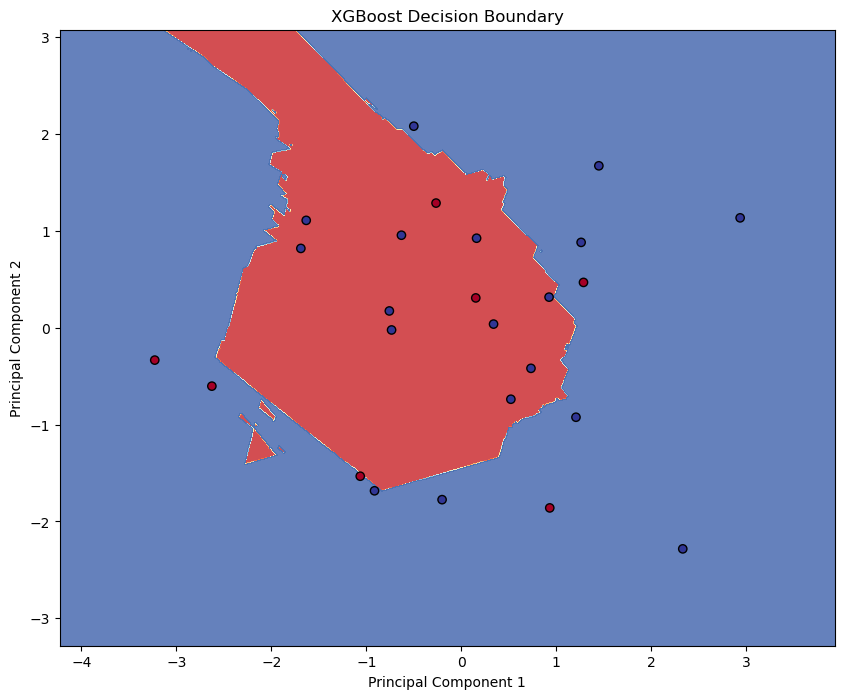

2024-12-17 09:39:43,775 - INFO - Generating feature importance plots for XGBoost...
INFO:__main__:Generating feature importance plots for XGBoost...


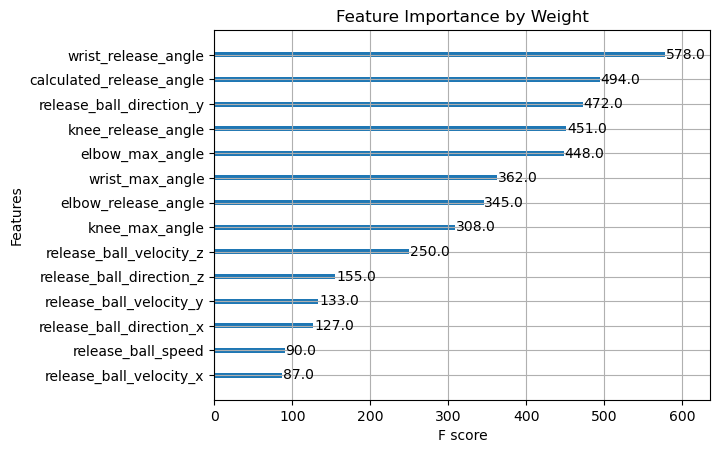

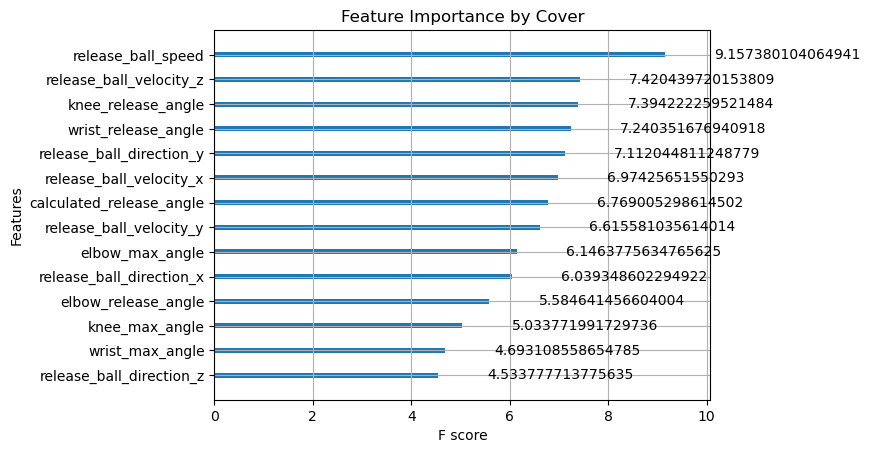

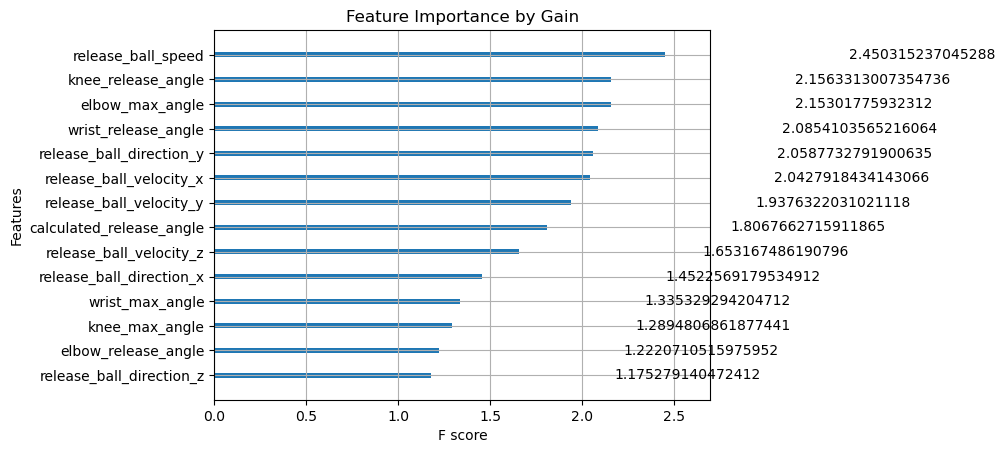

2024-12-17 09:39:44,137 - INFO - Model saved to ../../data/model/XGBoost_model.pkl
INFO:__main__:Model saved to ../../data/model/XGBoost_model.pkl
2024-12-17 09:39:44,145 - INFO - Started MLflow run: Model_Tuning_and_Evaluation_Run_Best_Model
INFO:__main__:Started MLflow run: Model_Tuning_and_Evaluation_Run_Best_Model
2024-12-17 09:39:44,148 - INFO - Best model based on Log Loss: XGBoost
INFO:__main__:Best model based on Log Loss: XGBoost
2024-12-17 09:39:44,149 - INFO - Best Log Loss: 0.7256280486760244
INFO:__main__:Best Log Loss: 0.7256280486760244
2024-12-17 09:39:44,161 - INFO - Started MLflow run: Model_Tuning_and_Evaluation_Run_Tuning_Results
INFO:__main__:Started MLflow run: Model_Tuning_and_Evaluation_Run_Tuning_Results
2024-12-17 09:39:44,180 - INFO - Tuning results saved to '../../data/model/tuning_results/tuning_results.json'.
INFO:__main__:Tuning results saved to '../../data/model/tuning_results/tuning_results.json'.
2024-12-17 09:39:44,181 - INFO - Loading model: XGBoost


Pipeline and assets loaded from ../../data/model/pipeline/preprocessing_assets.pkl
Loaded asset keys: ['fitted_pipelines', 'feature_indices', 'flattened_feature_indices', 'feature_name_to_index', 'label_encoder']
[Debug] Key: fitted_pipelines, Type: <class 'dict'>
[Debug] Sample from fitted_pipelines: ['numerical_scaler', 'numerical_minmax']
[Debug] Key: feature_indices, Type: <class 'dict'>
[Debug] Sample from feature_indices: ['numerical_scaler', 'numerical_minmax']
[Debug] Key: flattened_feature_indices, Type: <class 'dict'>
[Debug] Sample from flattened_feature_indices: [0, 1, 2, 3, 4]
[Debug] Key: feature_name_to_index, Type: <class 'dict'>
[Debug] Sample from feature_name_to_index: ['release_ball_direction_z', 'release_ball_velocity_z', 'knee_max_angle', 'wrist_release_angle', 'wrist_max_angle']
[Debug] Key: label_encoder, Type: <class 'sklearn.preprocessing._label.LabelEncoder'>

[Inverse numerical_scaler] Features: ['release_ball_direction_z', 'release_ball_velocity_z', 'knee_m

In [27]:
#%%writefile ../../src/freethrow_predictions/ml/train.py
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
# from mlflow.mlflow_logger import MLflowLogger  # Ensure this path is correct
# from mlflow.mlflow_logger import MLflowLogger
# from ml.train_utils.train import (evaluate_model,
#                                   save_model,
#                                   load_model, 
#                                   plot_decision_boundary, 
#                                   tune_random_forest, 
#                                   tune_xgboost, 
#                                   tune_decision_tree)
import joblib
import os
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)



def bayes_best_model_train(
    X_train,
    y_train,
    X_test,
    y_test,
    selection_metric="Log Loss",
    use_pca=True,
    save_dir="tuning_results.json",
    model_save_dir="../../data/model",
    classification_save_path="classification_reports.txt",
    selected_models=None,
    mlflow_logger=None,  # Pass MLflowLogger instance
):
    logger.info(f"X_train shape: {X_train.shape}")
    logger.info(f"y_train shape: {y_train.shape}")
    logger.info(f"X_test shape: {X_test.shape}")
    logger.info(f"y_test shape: {y_test.shape}")

    if mlflow_logger is None:
        mlflow_logger = MLflowLogger(
            tracking_uri="file:///absolute/path/to/mlruns",
            experiment_name="Model_Tuning_and_Evaluation",
            enable_mlflow=True
        )
    
    # Determine the appropriate scoring metric based on the selection_metric
    if selection_metric.lower() == "log loss":
        scoring_metric = "neg_log_loss"
    else:
        scoring_metric = "accuracy"

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    model_registry = {
        "Random Forest": tune_random_forest,
        "XGBoost": tune_xgboost,
        "Decision Tree": tune_decision_tree,
    }

    if selected_models is None:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Defaulting to all models: {selected_models}")
    elif isinstance(selected_models, str):
        selected_models = [selected_models]
        logger.info(f"Selected models (converted to list): {selected_models}")
    else:
        logger.info(f"Selected models: {selected_models}")
    
    selected_models_normalized = [model.lower() for model in selected_models]
    model_registry_normalized = {name.lower(): name for name in model_registry.keys()}

    # Filter out valid models
    valid_model_keys = [model_registry_normalized[model] for model in selected_models_normalized if model in model_registry_normalized]
    tuners_to_run = {name: model_registry[name] for name in valid_model_keys}

    # Identify invalid models
    invalid_models = set([model for model in selected_models if model.lower() not in model_registry_normalized])
    if invalid_models:
        logger.warning(f"The following models are invalid and will be ignored: {invalid_models}")
    
    if not tuners_to_run:
        logger.error("No valid models to train. Exiting the training process.")
        return

    # Start MLflow run
    run_name = "Model_Tuning_and_Evaluation_Run"
    params = {
        "selection_metric": selection_metric,
        "use_pca": use_pca,
        "selected_models": selected_models,
        "scoring_metric": scoring_metric
    }
    metrics = {}
    artifacts = [save_dir]
    
    mlflow_logger.log_run(
        run_name=run_name,
        params=params,
        metrics=metrics,  # Will be updated after tuning
        artifacts=artifacts,
        tags=None,
        datasets=None,
        nested=False
    )

    for model_name, tuner in tuners_to_run.items():
        logger.info(f"Tuning hyperparameters for {model_name}...")
        
        best_params, best_score, best_model_instance = tuner(X_train, y_train, scoring_metric=scoring_metric)
        metrics = evaluate_model(best_model_instance, X_test, y_test, save_path=classification_save_path)
        
        # Log metrics and parameters using MLflowLogger
        mlflow_logger.log_run(
            run_name=f"{run_name}_{model_name}",
            params=best_params,
            metrics=metrics,
            artifacts=None,
            tags=None,
            datasets=None,
            nested=True
        )
        
        tuning_results[model_name] = {
            "Best Params": best_params,
            "Best Cross-Validation Score": best_score,
            "Evaluation Metrics": metrics,
        }
        
        logger.info(f"{model_name} Best Params: {best_params}")
        logger.info(f"{model_name} Best Cross-Validation Score: {best_score}")
        logger.info(f"{model_name} Evaluation Metrics: {metrics}")

        metric_value = metrics.get(selection_metric)
        if metric_value is not None and (
            best_metric_value is None or
            (selection_metric.lower() == "log loss" and metric_value < best_metric_value) or
            (selection_metric.lower() != "log loss" and metric_value > best_metric_value)
        ):
            best_metric_value = metric_value
            best_model_name = model_name
            best_model = best_model_instance

        try:
            plot_decision_boundary(
                best_model_instance,
                X_test,
                y_test,
                f"{model_name} Decision Boundary",
                use_pca
            )
        except ValueError as e:
            logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

        # Add feature importance plots for XGBoost
        if model_name.lower() == "xgboost":
            logger.info("Generating feature importance plots for XGBoost...")
            try:
                xgb.plot_importance(best_model_instance, importance_type="weight")
                plt.title("Feature Importance by Weight")
                plt.show()

                xgb.plot_importance(best_model_instance, importance_type="cover")
                plt.title("Feature Importance by Cover")
                plt.show()

                xgb.plot_importance(best_model_instance, importance_type="gain")
                plt.title("Feature Importance by Gain")
                plt.show()
            except Exception as e:
                logger.error(f"Error generating feature importance plots: {e}")
    
    if best_model_name:
        save_model(
            best_model,
            model_name=best_model_name,
            save_dir=model_save_dir,
        )

    # Log the best model information
    mlflow_logger.log_run(
        run_name=f"{run_name}_Best_Model",
        params={"best_model_name": best_model_name},
        metrics={"best_metric_value": best_metric_value},
        artifacts=None,
        tags=None,
        datasets=None,
        nested=True
    )

    logger.info(f"Best model based on {selection_metric}: {best_model_name}")
    logger.info(f"Best {selection_metric}: {best_metric_value}")

    with open(save_dir, "w") as f:
        json.dump(tuning_results, f, indent=4)
    mlflow_logger.log_run(
        run_name=f"{run_name}_Tuning_Results",
        params=None,
        metrics=None,
        artifacts=save_dir,
        tags=None,
        datasets=None,
        nested=True
    )
    logger.info(f"Tuning results saved to '{save_dir}'.")


if __name__ == "__main__":
    
    # from classification_processors.datapreprocessor_class import DataPreprocessor
    # from classification_processors.inverse_preprocessor_class import InversePreprocessor
    # Example 1: With train-test split
    # File paths
    features_path = '../../data/model/pipeline/final_ml_df_selected_features_columns.pkl'
    dataset_path = "../../data/processed/final_ml_dataset.csv"
    assets_path = '../../data/model/pipeline/preprocessing_assets.pkl'
    model_save_dir="../../data/model"
    tuning_results_save = "../../data/model/tuning_results/tuning_results.json"
    classification_save_path="../../data/model/classification_reports/classification_reports.txt"
    selected_models="XGBoost" # can choose decision tree or random forest, or set to None to find best of all 3
    selection_metric="Log Loss" # bayesian optimized metric, can choose accuracy or others as well
    
    # Initialize MLflowLogger
    mlflow_logger = MLflowLogger(
        tracking_uri="file:///absolute/path/to/mlruns",  # Ensure this path exists
        experiment_name="Model_Tuning_and_Evaluation",
        enable_mlflow=True  # Set to False to disable MLflow logging
    )
    
    # Example 1: With train-test split
    dp_split = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        y_variable='result',
        preprocessor_train_test_split=True,
        test_size=0.2,
        random_state=123,
        stratify=True,
    )
    (
        X_train_transformed,
        X_test_transformed,
        y_train_encoded,
        y_test_encoded,
        transformed_data_train,
        transformed_train_df,  # Include the additional output
        X_train,
        y_train,
    ) = dp_split.run()


    print(f"X_train_transformed shape: {X_train_transformed.shape}")
    print(f"X_test_transformed shape: {X_test_transformed.shape}")
    print(f"Transformed Data Train: {transformed_data_train.keys()}")
    print(f"Original X_train shape: {X_train.shape}")
    print(f"Original y_train shape: {y_train.shape}")
    
    # --------------------------Best Model Bayes Optim Search------------------
    # Start hyperparameter tuning and evaluation
    logger.info("Starting hyperparameter tuning and evaluation...")
    bayes_best_model_train(
        X_train=X_train_transformed,
        y_train=y_train_encoded,
        X_test=X_test_transformed,
        y_test=y_test_encoded,
        selection_metric=selection_metric,
        use_pca=True,
        save_dir=tuning_results_save,
        model_save_dir=model_save_dir,
        classification_save_path=classification_save_path,
        selected_models="XGBoost",
        mlflow_logger=mlflow_logger  # Pass the MLflowLogger instance
    )
    
    # --------------------custom predict------------------------
    # Optionally load a pre-saved model and make predictions
    # from predict import load_model
    
    load_model_name="XGBoost"
    logger.info(f"Loading model: {load_model_name}")
    loaded_model = load_model(load_model_name, save_dir=model_save_dir)
    y_pred = loaded_model.predict(X_test_transformed)
    logger.info(f"Predictions from loaded model: {y_pred}")


    # ------------Inverse transform and put y_variable_original back on-----------
    # Initialize InversePreprocessor with assets_path (no need to preload assets manually)
    inverse_transformer = InversePreprocessor(
        assets_path=assets_path,  # Assets will be loaded automatically
        debug=True
    )

    # Perform inverse transformation and combine with targets
    final_dataset = inverse_transformer.transform(
        original_data=X_train,
        transformed_data=transformed_data_train,
        y_encoded=y_train_encoded
    )

    # Display the resulting dataset
    print("[Final Dataset]:")
    print(final_dataset.head())




# Shap Functions for Prediction Module

### Prediction Module

In [28]:
#%%writefile ../../src/freethrow_predictions/ml/shap/shap_utils.py

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


def setup_logging(debug: bool = False) -> logging.Logger:
    """
    Configure and return a logger.

    :param debug: If True, set logging level to DEBUG. Otherwise, INFO.
    :return: Configured logger.
    """
    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(level=level, 
                        format='%(asctime)s - %(levelname)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    logger = logging.getLogger(__name__)
    return logger


def compute_shap_values(model, X_transformed: pd.DataFrame, debug: bool = False, logger: logging.Logger = None):
    """
    Compute SHAP values for the transformed data.

    :param model: Trained machine learning model.
    :param X_transformed: Transformed features used for prediction (pd.DataFrame).
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Tuple of (explainer, shap_values).
    """
    if logger:
        logger.info("Initializing SHAP explainer...")
    try:
        explainer = shap.Explainer(model, X_transformed)
        shap_values = explainer(X_transformed)
        if logger:
            logger.info("SHAP values computed successfully.")
            if debug:
                logger.debug(f"SHAP values shape: {shap_values.values.shape}")
    except Exception as e:
        if logger:
            logger.error(f"SHAP value computation failed: {e}")
        raise
    return explainer, shap_values


def plot_shap_summary(shap_values, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                      logger: logging.Logger = None):
    """
    Generate and save a SHAP summary plot.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info("Generating SHAP summary plot...")
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP summary plot saved to {save_path}")
        if logger:
            logger.info("SHAP summary plot generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP summary plot: {e}")
        raise


def plot_shap_dependence(shap_values, feature: str, X_original: pd.DataFrame, save_path: str, debug: bool = False, 
                         logger: logging.Logger = None):
    """
    Generate and save a SHAP dependence plot for a specific feature.

    :param shap_values: SHAP values computed for the dataset.
    :param feature: Feature name to generate the dependence plot for.
    :param X_original: Original (untransformed) feature DataFrame.
    :param save_path: Full file path to save the plot.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    """
    if logger:
        logger.info(f"Generating SHAP dependence plot for feature '{feature}'...")
    try:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, shap_values.values, X_original, show=False)
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        if logger and debug:
            logger.debug(f"SHAP dependence plot for '{feature}' saved to {save_path}")
        if logger:
            logger.info(f"SHAP dependence plot for feature '{feature}' generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP dependence plot for feature '{feature}': {e}")
        raise


def generate_global_recommendations(shap_values, X_original: pd.DataFrame, top_n: int = 5, debug: bool = False, 
                                    use_mad: bool = False, logger: logging.Logger = None) -> dict:
    """
    Generate global recommendations based on SHAP values and feature distributions.

    :param shap_values: SHAP values computed for the dataset.
    :param X_original: Original (untransformed) feature DataFrame.
    :param top_n: Number of top features to generate recommendations for.
    :param debug: If True, enable detailed debug logs.
    :param use_mad: If True, use Median Absolute Deviation for range definition.
    :param logger: Logger instance for logging.
    :return: recommendations: Dictionary mapping features to recommended value ranges, importance, and direction.
    """
    if logger:
        logger.info("Generating feature importance based on SHAP values...")
    try:
        shap_df = pd.DataFrame(shap_values.values, columns=X_original.columns)
        
        # Calculate mean absolute SHAP values for importance
        feature_importance = pd.DataFrame({
            'feature': X_original.columns,
            'importance': np.abs(shap_df).mean(axis=0),
            'mean_shap': shap_df.mean(axis=0)
        }).sort_values(by='importance', ascending=False)
        
        if logger and debug:
            logger.debug(f"Feature importance (top {top_n}):\n{feature_importance.head(top_n)}")
        
        top_features = feature_importance.head(top_n)['feature'].tolist()
        recommendations = {}
        
        for feature in top_features:
            feature_values = X_original[feature]
            
            if use_mad:
                # Use Median and MAD for robust statistics
                median = feature_values.median()
                mad = feature_values.mad()
                lower_bound = median - 1.5 * mad
                upper_bound = median + 1.5 * mad
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            else:
                # Default to Interquartile Range (IQR)
                lower_bound = feature_values.quantile(0.25)
                upper_bound = feature_values.quantile(0.75)
                range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            
            # Determine direction based on mean SHAP value
            mean_shap = feature_importance.loc[feature_importance['feature'] == feature, 'mean_shap'].values[0]
            direction = 'positive' if mean_shap > 0 else 'negative'
            
            recommendations[feature] = {
                'range': range_str,
                'importance': round(feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0], 4),  # Rounded for readability
                'direction': direction
            }
            if logger and debug:
                logger.debug(f"Recommendation for {feature}: Range={range_str}, Importance={feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0]}, Direction={direction}")
        
        if logger and debug:
            logger.debug(f"Final Recommendations with Importance and Direction: {recommendations}")
        return recommendations
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate global recommendations: {e}")
        raise


def generate_individual_feedback(trial: pd.Series, shap_values_trial: np.ndarray, feature_metadata: dict = None, 
                                 logger: logging.Logger = None) -> dict:
    """
    Generate specific feedback for a single trial based on its SHAP values and feature metadata.

    Args:
        trial (pd.Series): A single trial's data.
        shap_values_trial (np.ndarray): SHAP values for the trial.
        feature_metadata (dict, optional): Additional metadata for features (e.g., units).
        logger (logging.Logger, optional): Logger instance for logging.

    Returns:
        dict: Feedback messages for each feature.
    """
    feedback = {}
    feature_names = trial.index.tolist()

    for feature, shap_value in zip(feature_names, shap_values_trial):
        if shap_value > 0:
            adjustment = "maintain or increase"
            direction = "positively"
        elif shap_value < 0:
            adjustment = "decrease"
            direction = "positively"
        else:
            feedback[feature] = f"{feature.replace('_', ' ').capitalize()} has no impact on the prediction."
            continue

        # Map SHAP values to meaningful adjustment magnitudes
        # Example: 10% of the current feature value
        current_value = trial[feature]
        adjustment_factor = 0.1
        adjustment_amount = adjustment_factor * abs(current_value)

        # Incorporate feature metadata if available
        if feature_metadata and feature in feature_metadata:
            unit = feature_metadata[feature].get('unit', '')
            adjustment_str = f"{adjustment_amount:.2f} {unit}" if unit else f"{adjustment_amount:.2f}"
        else:
            adjustment_str = f"{adjustment_amount:.2f}"

        # Construct feedback message
        feedback_message = (
            f"Consider to {adjustment} '{feature.replace('_', ' ')}' by approximately {adjustment_str} "
            f"to {direction} influence the result."
        )
        feedback[feature] = feedback_message

    return feedback


def compute_individual_shap_values(explainer, X_transformed: pd.DataFrame, trial_index: int, 
                                   logger: logging.Logger = None):
    """
    Compute SHAP values for a single trial.

    :param explainer: SHAP explainer object.
    :param X_transformed: Transformed features used for prediction.
    :param trial_index: Index of the trial.
    :param logger: Logger instance.
    :return: shap_values for the trial.
    """
    if logger:
        logger.info(f"Computing SHAP values for trial at index {trial_index}...")
    try:
        trial = X_transformed.iloc[[trial_index]]
        shap_values = explainer(trial)
        if logger:
            logger.debug(f"SHAP values for trial {trial_index} computed successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to compute SHAP values for trial {trial_index}: {e}")
        raise
    return shap_values


def plot_individual_shap_force(shap_explainer, shap_values, X_original: pd.DataFrame, trial_index: int, 
                               save_path: str, logger: logging.Logger = None):
    """
    Generate and save a SHAP force plot for a specific trial.

    :param shap_explainer: SHAP explainer object.
    :param shap_values: SHAP values for the trial.
    :param X_original: Original feature DataFrame.
    :param trial_index: Index of the trial.
    :param save_path: Full file path to save the force plot.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Generating SHAP force plot for trial {trial_index}...")
    try:
        shap_plot = shap.force_plot(
            shap_explainer.expected_value, 
            shap_values.values[0], 
            X_original.iloc[trial_index],
            matplotlib=False
        )
        shap.save_html(save_path, shap_plot)
        if logger:
            logger.debug(f"SHAP force plot saved to {save_path}")
            logger.info(f"SHAP force plot for trial {trial_index} generated successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to generate SHAP force plot for trial {trial_index}: {e}")
        raise


def extract_force_plot_values(shap_values, trial_index: int, logger: logging.Logger = None) -> dict:
    """
    Extract SHAP values and feature contributions for a specific trial.

    Args:
        shap_values (shap.Explanation): SHAP values object.
        trial_index (int): Index of the trial.
        logger (logging.Logger, optional): Logger instance.

    Returns:
        dict: Dictionary of feature contributions.
    """
    try:
        shap_values_instance = shap_values.values[trial_index]
        features_instance = shap_values.data[trial_index]
        feature_contributions = dict(zip(shap_values.feature_names, shap_values_instance))
        if logger and logger.isEnabledFor(logging.DEBUG):
            logger.debug(f"SHAP values for trial {trial_index}: {feature_contributions}")
        return feature_contributions
    except Exception as e:
        if logger:
            logger.error(f"Error extracting SHAP values for trial {trial_index}: {e}")
        raise


def save_shap_values(shap_values, save_path: str, logger: logging.Logger = None):
    """
    Save SHAP values to a file using pickle.

    :param shap_values: SHAP values object to save.
    :param save_path: File path to save the SHAP values.
    :param logger: Logger instance.
    """
    if logger:
        logger.info(f"Saving SHAP values to {save_path}...")
    try:
        with open(save_path, "wb") as f:
            pickle.dump(shap_values, f)
        if logger:
            logger.info(f"SHAP values saved successfully to {save_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to save SHAP values: {e}")
        raise


def load_shap_values(load_path: str, logger: logging.Logger = None):
    """
    Load SHAP values from a pickle file.

    :param load_path: File path to load the SHAP values from.
    :param logger: Logger instance.
    :return: Loaded SHAP values object.
    """
    if logger:
        logger.info(f"Loading SHAP values from {load_path}...")
    try:
        with open(load_path, "rb") as f:
            shap_values = pickle.load(f)
        if logger:
            logger.info(f"SHAP values loaded successfully from {load_path}.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load SHAP values: {e}")
        raise
    return shap_values


In [29]:
#%%writefile ../../src/freethrow_predictions/ml/predict.py

import json
import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
# from shap_utils import (
#     setup_logging,
#     compute_shap_values,
#     plot_shap_summary,
#     plot_shap_dependence,
#     generate_global_recommendations,
#     compute_individual_shap_values,
#     plot_individual_shap_force,
#     extract_force_plot_values,
#     save_shap_values,
#     load_shap_values
# )
# from classification_processors.datapreprocessor_class import DataPreprocessor
# from classification_processors.inverse_preprocessor_class import InversePreprocessor
# from train import load_model  # Ensure 'train.py' is correctly implemented


def preprocess_data(config: dict, data: pd.DataFrame = None, debug: bool = False, 
                   logger: logging.Logger = None):
    """
    Preprocess the dataset or a specific instance using the DataPreprocessor class.

    :param config: Configuration dictionary with paths and parameters.
    :param data: Optional DataFrame containing the new data to preprocess.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Tuple containing X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y
    """
    if logger:
        logger.info("Initializing DataPreprocessor...")
    dp = DataPreprocessor(
        features_path=config["features_path"],
        dataset_path=config["dataset_path"],
        assets_path=config["assets_path"],
        y_variable=config["y_variable"],
        preprocessor_train_test_split=False
    )

    # If data is provided, use it instead of loading a dataset from disk.
    if data is not None:
        X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y = dp.run(data)
    else:
        X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y = dp.run()
    
    if logger and debug:
        logger.debug(f"Preprocessed DataFrame shape: {X.shape}")
        logger.debug(f"Transformed Data Shape: {X_transformed.shape}")
    
    return X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y


def predict_with_model(X_transformed: pd.DataFrame, model_name: str, config: dict, 
                      debug: bool = False, logger: logging.Logger = None):
    """
    Load a pre-trained model and make predictions along with prediction probabilities.

    :param X_transformed: Transformed features for prediction.
    :param model_name: Name of the model to load.
    :param config: Configuration dictionary with paths.
    :param debug: If True, enable debug logging in load_model.
    :param logger: Logger instance for logging.
    :return: Tuple of (predictions, prediction_probabilities, model)
    """
    if logger:
        logger.info(f"Loading model: {model_name}")
        logger.debug(f"Loading model with debug={debug}")
    model = load_model(model_name, save_dir=config["model_save_dir"])
    if logger:
        logger.debug(f"Model loaded successfully: {model}")

    if logger:
        logger.info("Generating class predictions...")
    predictions = model.predict(X_transformed)
    if logger and debug:
        logger.debug(f"Predictions shape: {predictions.shape}")
        logger.debug(f"Predictions (first 5): {predictions[:5]}")
    
    if logger:
        logger.info("Generating prediction probabilities...")
    if hasattr(model, "predict_proba"):
        prediction_probabilities = model.predict_proba(X_transformed)
        if logger and debug:
            logger.debug(f"Prediction probabilities shape: {prediction_probabilities.shape}")
            logger.debug(f"Prediction probabilities (first 5):\n{prediction_probabilities[:5, :]}")
    else:
        if logger:
            logger.warning(f"The model '{model_name}' does not support 'predict_proba'.")
        prediction_probabilities = None

    return predictions, prediction_probabilities, model


def inverse_transform_data(X: pd.DataFrame, transformed_data: pd.DataFrame, y_encoded: np.ndarray, 
                          config: dict, debug: bool = False, logger: logging.Logger = None):
    """
    Perform inverse transformation to combine transformed and original data.

    :param X: Original features.
    :param transformed_data: Transformed features.
    :param y_encoded: Encoded labels.
    :param config: Configuration dictionary with paths.
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Tuple of (final_dataset, inverse_transformer)
    """
    if logger:
        logger.info("Performing inverse transformation...")
    inverse_transformer = InversePreprocessor(
        assets_path=config["assets_path"],
        debug=debug,
    )
    final_dataset = inverse_transformer.transform(
        original_data=X,
        transformed_data=transformed_data,
        y_encoded=y_encoded,
    )
    if logger and debug:
        logger.debug(f"Final dataset after inverse transformation shape: {final_dataset.shape}")
        logger.debug(f"Columns added during inverse transformation: {list(final_dataset.columns)}")
    if logger:
        logger.info("Inverse transformation completed.")
    return final_dataset, inverse_transformer


def append_columns_from_original_predictions(final_dataset: pd.DataFrame, original_data: pd.DataFrame, 
                                            inverse_transformer: InversePreprocessor, 
                                            columns_to_append_with_opt: list = ["trial_id"], 
                                            debug: bool = False, logger: logging.Logger = None) -> pd.DataFrame:
    """
    Add back columns from Original dataset before feature selection for machine learning.

    :param final_dataset: DataFrame after inverse transformation.
    :param original_data: Original DataFrame.
    :param inverse_transformer: Instance of InversePreprocessor.
    :param columns_to_append_with_opt: List of column names to append.
    :param debug: Boolean flag for debugging.
    :param logger: Logger instance for logging.
    :return: Updated DataFrame with appended columns.
    """
    final_dataset = inverse_transformer.append_columns_from_original(
        final_dataset=final_dataset,
        original_data=original_data,
        columns_to_append=columns_to_append_with_opt,
        debug=debug
    )
    if logger and debug:
        logger.debug(f"Columns appended: {columns_to_append_with_opt}")
    if logger:
        logger.info("Columns appended successfully.")
    return final_dataset


def add_predictions_to_dataset(final_dataset: pd.DataFrame, predictions: np.ndarray, 
                               y_variable: str, debug: bool = False, 
                               logger: logging.Logger = None) -> pd.DataFrame:
    """
    Add predictions to the final dataset as a new column.

    :param final_dataset: DataFrame containing the final processed dataset.
    :param predictions: Array or list of predictions generated by the model.
    :param y_variable: The target variable name (used for naming the predictions column).
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Updated DataFrame with predictions added as a new column.
    """
    predictions_column_name = f"{y_variable}_prediction"
    if logger:
        logger.info(f"Adding predictions to the dataset as column '{predictions_column_name}'...")
    final_dataset[predictions_column_name] = predictions
    if logger and debug:
        logger.debug(f"Added column '{predictions_column_name}'.")
    if logger:
        logger.info("Predictions added successfully.")
    return final_dataset


def add_prediction_probabilities_to_dataset(final_dataset: pd.DataFrame, prediction_probabilities: np.ndarray, 
                                           classes: list, y_variable: str, debug: bool = False, 
                                           logger: logging.Logger = None) -> pd.DataFrame:
    """
    Add prediction probabilities to the final dataset as new columns.

    For binary classification, only the probability of the positive class is added.

    :param final_dataset: DataFrame containing the final processed dataset.
    :param prediction_probabilities: Array or list of prediction probabilities from the model.
    :param classes: Array of class labels corresponding to the probabilities.
    :param y_variable: The target variable name (used for naming the probability columns).
    :param debug: If True, enable detailed debug logs.
    :param logger: Logger instance for logging.
    :return: Updated DataFrame with prediction probabilities added as new columns.
    """
    if logger:
        logger.info("Adding prediction probabilities to the dataset...")
    
    try:
        # Validate the shape of prediction_probabilities
        if prediction_probabilities.ndim != 2 or prediction_probabilities.shape[1] != len(classes):
            if logger:
                logger.error("Prediction probabilities have an unexpected shape.")
            raise ValueError("Invalid shape for prediction_probabilities.")
    
        if len(classes) == 2:
            positive_class = classes[1]
            prob_column_name = f"{y_variable}_probability_class_{positive_class}"
            final_dataset[prob_column_name] = prediction_probabilities[:, 1]
            if logger and debug:
                logger.debug(f"Added probability column '{prob_column_name}'.")
        else:
            for idx, class_label in enumerate(classes):
                prob_column_name = f"{y_variable}_probability_class_{class_label}"
                final_dataset[prob_column_name] = prediction_probabilities[:, idx]
                if logger and debug:
                    logger.debug(f"Added probability column '{prob_column_name}'.")
    
        if logger:
            logger.info("Prediction probabilities added successfully.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to add prediction probabilities: {e}")
        raise
    
    return final_dataset


def generate_specific_feedback(trial: pd.Series, recommendations: dict, logger: logging.Logger = None) -> dict:
    """
    Generate specific feedback for a single trial based on feature values and recommendations.

    Args:
        trial (pd.Series): A single trial's data.
        recommendations (dict): Global recommendations for features.
        logger (logging.Logger, optional): Logger instance for logging.

    Returns:
        feedback (dict): Feedback messages for each feature.
    """
    feedback = {}
    for feature, rec in recommendations.items():
        range_str = rec.get('range', '')
        direction = rec.get('direction', 'positive')  # Default to 'positive' if not specified
        try:
            min_val, max_val = map(float, range_str.split('–'))
        except ValueError:
            if logger:
                logger.error(f"Invalid range format for feature '{feature}': {range_str}")
            feedback[feature] = "No feedback available due to invalid recommendation format."
            continue
        
        trial_value = trial[feature]
        within_range = min_val <= trial_value <= max_val

        # Determine the optimal direction based on SHAP directionality
        if direction == 'positive':
            if trial_value < min_val:
                adjustment = "increase"
                adjustment_amount = min_val - trial_value
                feedback[feature] = f"Consider increasing '{feature.replace('_', ' ')}' by ~{adjustment_amount:.1f} to positively influence the result."
            elif trial_value > max_val:
                adjustment = "decrease"
                adjustment_amount = trial_value - max_val
                feedback[feature] = f"Consider decreasing '{feature.replace('_', ' ')}' by ~{adjustment_amount:.1f} to positively influence the result."
            else:
                feedback[feature] = f"'{feature.replace('_', ' ').capitalize()}' is within the optimal range."
        else:
            if trial_value < min_val:
                adjustment = "decrease"
                adjustment_amount = min_val - trial_value
                feedback[feature] = f"Consider decreasing '{feature.replace('_', ' ')}' by ~{adjustment_amount:.1f} to positively influence the result."
            elif trial_value > max_val:
                adjustment = "increase"
                adjustment_amount = trial_value - max_val
                feedback[feature] = f"Consider increasing '{feature.replace('_', ' ')}' by ~{adjustment_amount:.1f} to positively influence the result."
            else:
                feedback[feature] = f"'{feature.replace('_', ' ').capitalize()}' is within the optimal range."
    
    return feedback


def predict(
    config: dict, 
    latest_trial_only: bool = False, 
    overall_shap_trends_data_and_graphs_path: str = None,
    trial_specific_graphs_path: str = None,
    output_data_path: str = None,
    include_specific_feedback: bool = False,
    debug: bool = True
):
    """
    Execute the prediction pipeline with SHAP analysis and generate recommendations.

    :param config: Configuration dictionary with paths and parameters.
    :param latest_trial_only: If True, compute SHAP for the latest trial only.
    :param overall_shap_trends_data_and_graphs_path: Path to save overall SHAP trends and graphs.
    :param trial_specific_graphs_path: Path to save trial-specific SHAP plots.
    :param output_data_path: Path to save the final dataset with predictions.
    :param include_specific_feedback: If True, include specific feedback in the dataset.
    :param debug: If True, enable detailed debug logs.
    :return: Tuple of (final_dataset_with_predictions, recommendations, shap_values)
    """
    try:
        # Initialize logger with the debug flag
        logger = setup_logging(debug=debug)
        logger.info("Starting the prediction pipeline...")
        
        # Step 1: Preprocess data
        X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y = preprocess_data(
            config, debug=debug, logger=logger
        )
        
        # Step 2: Make predictions and get probabilities
        predictions, prediction_probabilities, model = predict_with_model(
            X_transformed=X_transformed,
            model_name=config["selected_models"],
            config=config,
            debug=debug,
            logger=logger
        )
        
        # Step 3: Inverse transformation
        final_dataset, inverse_transformer = inverse_transform_data(
            X=X,
            transformed_data=transformed_data,
            y_encoded=y_encoded,
            config=config,
            debug=debug,
            logger=logger
        )
        
        # Step 4: Append Original Columns
        final_dataset = append_columns_from_original_predictions(
            final_dataset=final_dataset,
            original_data=original_data,
            inverse_transformer=inverse_transformer,
            columns_to_append_with_opt=["trial_id"],
            debug=debug,
            logger=logger
        )
        
        # Step 5: Add predictions to the dataset
        final_dataset_with_predictions = add_predictions_to_dataset(
            final_dataset=final_dataset,
            predictions=predictions,
            y_variable=config["y_variable"],
            debug=debug,
            logger=logger
        )
        
        # Step 6: Add prediction probabilities to the dataset
        if prediction_probabilities is not None:
            final_dataset_with_predictions = add_prediction_probabilities_to_dataset(
                final_dataset=final_dataset_with_predictions,
                prediction_probabilities=prediction_probabilities,
                classes=model.classes_,
                y_variable=config["y_variable"],
                debug=debug,
                logger=logger
            )
        
        # Step 7: Compute SHAP values for global recommendations
        logger.info("Computing SHAP values for global recommendations...")
        explainer, shap_values = compute_shap_values(model, X_transformed, debug=debug, logger=logger)
        
        # Step 8: Initialize paths without automated naming
        overall_shap_path = overall_shap_trends_data_and_graphs_path or config.get("overall_shap_trends_data_and_graphs_path", "../../data/model/predictions/shap_outputs/overall_shap_trends")
        trial_specific_path = trial_specific_graphs_path or config.get("trial_specific_graphs_path", "../../data/model/predictions/shap_outputs/trial_specific")
        output_data_path = output_data_path or config.get("output_data_path", "../../data/model/predictions")
        
        # Create directories if they do not exist
        os.makedirs(overall_shap_path, exist_ok=True)
        os.makedirs(trial_specific_path, exist_ok=True)
        os.makedirs(output_data_path, exist_ok=True)
        
        # Step 9: Generate and save SHAP summary plot
        shap_summary_filename = "shap_summary.png"
        shap_summary_path = os.path.join(overall_shap_path, shap_summary_filename)
        plot_shap_summary(
            shap_values=shap_values, 
            X_original=X, 
            save_path=shap_summary_path, 
            debug=debug, 
            logger=logger
        )
        
        # Step 10: Generate and save SHAP dependence plots for top features
        top_n = len(X.columns)  # Can be adjusted based on requirements
        recommendations = generate_global_recommendations(
            shap_values=shap_values, 
            X_original=X, 
            top_n=top_n, 
            debug=debug, 
            use_mad=False,  # Set to True if using MAD for range definitions
            logger=logger
        )
        for feature in recommendations.keys():
            sanitized_feature = feature.replace(" ", "_").replace("/", "_")
            shap_dependence_filename = f"shap_dependence_{sanitized_feature}.png"
            shap_dependence_path = os.path.join(overall_shap_path, shap_dependence_filename)
            plot_shap_dependence(
                shap_values=shap_values, 
                feature=feature, 
                X_original=X, 
                save_path=shap_dependence_path, 
                debug=debug, 
                logger=logger
            )
        
        # Step 11: Annotate final dataset with recommendations, importance, direction, and status
        logger.info("Annotating dataset with global recommendations, importance, direction, and status...")
        for feature, rec in recommendations.items():
            range_str = rec.get('range', '')
            importance = rec.get('importance', None)
            direction = rec.get('direction', 'positive')
            logger.debug(f"Processing feature '{feature}' with range '{range_str}', importance '{importance}', and direction '{direction}'")
            final_dataset_with_predictions[f"{feature}_shap_recommendation"] = range_str
            final_dataset_with_predictions[f"{feature}_shap_importance"] = importance  # Adding importance to the dataset
            final_dataset_with_predictions[f"{feature}_shap_direction"] = direction  # Adding direction to the dataset
            
            # Clean the range string
            clean_range_str = range_str.replace('°', '')
            try:
                min_val_str, max_val_str = clean_range_str.split('–')
                min_val = float(min_val_str)
                max_val = float(max_val_str)
                logger.debug(f"Parsed range for '{feature}': min={min_val}, max={max_val}")
            except ValueError as ve:
                logger.error(f"Invalid range format for feature '{feature}': {range_str}. Error: {ve}")
                final_dataset_with_predictions[f"{feature}_shap_status"] = "Invalid Range Format"
                continue
            
            # Apply the cleaned values
            final_dataset_with_predictions[f"{feature}_shap_status"] = final_dataset_with_predictions[feature].apply(
                lambda x: "Within Range" if min_val <= x <= max_val else (
                    "Below Range" if x < min_val else "Above Range"
                )
            )
            logger.debug(f"Annotated '{feature}_shap_status' column.")
        
        # Step 12: Generate specific feedback for each trial based on individual SHAP values
        if include_specific_feedback:
            logger.info("Generating specific feedback for each trial based on individual SHAP values...")
            
            # Dynamically create feature_metadata based on feature names
            feature_metadata = {}
            for feature in X.columns:
                if 'angle' in feature.lower():
                    unit = 'degrees'
                else:
                    unit = 'meters'
                feature_metadata[feature] = {'unit': unit}
            
            specific_feedback_list = []
            for idx in final_dataset_with_predictions.index:
                trial = final_dataset_with_predictions.loc[idx]
                shap_values_trial = shap_values.values[idx]
                feedback = generate_individual_feedback(trial, shap_values_trial, feature_metadata, logger=logger)
                specific_feedback_list.append(feedback)
                if logger and debug:
                    logger.debug(f"Generated feedback for trial {idx}: {feedback}")
            final_dataset_with_predictions['specific_feedback'] = specific_feedback_list
            logger.info("Specific feedback based on individual SHAP values generated for all trials.")
        else:
            logger.info("Specific feedback generation skipped as include_specific_feedback is False.")
        
        # Step 13: Optionally compute and plot SHAP for the latest trial
        if latest_trial_only:
            latest_trial_index = final_dataset_with_predictions.index[-1]
            shap_values_latest = compute_individual_shap_values(
                explainer=explainer, 
                X_transformed=X_transformed, 
                trial_index=latest_trial_index, 
                logger=logger
            )
            shap_force_filename = f"shap_force_plot_trial_{latest_trial_index}.html"
            shap_force_path = os.path.join(trial_specific_path, shap_force_filename)
            plot_individual_shap_force(
                shap_explainer=explainer,
                shap_values=shap_values_latest,
                X_original=X,
                trial_index=latest_trial_index,
                save_path=shap_force_path,
                logger=logger
            )
            logger.info(f"SHAP force plot for trial {latest_trial_index} saved to {shap_force_path}")
        
        # Step 14: Optionally drop specific feedback if not needed
        if not include_specific_feedback:
            # Drop the specific_feedback column if it exists
            if 'specific_feedback' in final_dataset_with_predictions.columns:
                final_dataset_with_predictions = final_dataset_with_predictions.drop(columns=['specific_feedback'])
                if logger:
                    logger.info("Specific feedback column dropped as include_specific_feedback is False.")
        
        # Step 15: Save the final dataset
        final_output_filename = "final_dataset_with_predictions_and_shap.csv"
        final_output_path = os.path.join(output_data_path, final_output_filename)
        final_dataset_with_predictions.to_csv(final_output_path, index=False)
        if logger:
            logger.info(f"Final dataset with predictions saved to {final_output_path}")
        
        # Step 16: Save the recommendation ranges, importance, and direction as a JSON file
        recommendations_filename = "global_shap_recommendations.json"
        recommendations_save_path = os.path.join(overall_shap_path, recommendations_filename)
        try:
            with open(recommendations_save_path, "w") as f:
                json.dump(recommendations, f, indent=4)
            if logger:
                logger.info(f"Global recommendations with SHAP importance and direction saved to {recommendations_save_path}")
        except Exception as e:
            if logger:
                logger.error(f"Failed to save global recommendations JSON: {e}")
            raise
        
        # Step 17: Add Debugging Outputs for Verification
        if debug:
            logger.debug(f"Recommendation Structure with SHAP Importance and Direction:\n{json.dumps(recommendations, indent=4)}")
            logger.debug(f"JSON Keys: {list(recommendations.keys())}")
            if recommendations:
                sample_feature = next(iter(recommendations))
                logger.debug(f"Sample Data for '{sample_feature}': {recommendations[sample_feature]}")
            else:
                logger.debug("No recommendations generated.")
        else:
            logger.info("Recommendations saved successfully with SHAP feature importance and direction.")
        
        logger.info("Prediction pipeline with recommendations completed successfully!")
        return final_dataset_with_predictions, recommendations, shap_values
    except Exception as e:
        logger.error(f"An error occurred in the prediction pipeline: {e}", exc_info=True)
        raise


if __name__ == "__main__":
    # Configuration paths (parameterize as needed)
    predict_config = {
        "features_path": "../../data/model/pipeline/final_ml_df_selected_features_columns.pkl",
        "dataset_path": "../../data/processed/final_ml_dataset.csv",
        "assets_path": "../../data/model/pipeline/preprocessing_assets.pkl",
        "model_save_dir": "../../data/model",
        "y_variable": "result",
        "selected_models": "XGBoost",
        "debug": True,  # Toggle debug mode here
        "overall_shap_trends_data_and_graphs_path": "../../data/model/predictions/shap_outputs/overall_shap_trends",
        "trial_specific_graphs_path": "../../data/model/predictions/shap_outputs/trial_specific",
        "output_data_path": "../../data/model/predictions",
    }
    
    # Example usage
    final_dataset_with_predictions, recommendations, shap_values = predict(
        config=predict_config, 
        latest_trial_only=True,
        overall_shap_trends_data_and_graphs_path=predict_config["overall_shap_trends_data_and_graphs_path"],
        trial_specific_graphs_path=predict_config["trial_specific_graphs_path"],
        output_data_path=predict_config["output_data_path"],
        include_specific_feedback=True,
        debug=predict_config["debug"]
    )
    
    # Minimal standard output
    if not predict_config["debug"]:
        print("Prediction pipeline executed successfully.")
    
    # Display the first few rows of the final dataset
    print(final_dataset_with_predictions.head())
    
    # Display global recommendations
    print("Global Recommendations:")
    for feature, rec in recommendations.items():
        print(f"{feature}: Range={rec['range']}, Importance={rec['importance']}, Direction={rec['direction']}")
    
    # Display specific feedback for each trial
    print("\nSpecific Feedback for Each Trial:")
    for idx, row in final_dataset_with_predictions.iterrows():
        print(f"Trial {idx + 1}:")
        for feature, feedback in row['specific_feedback'].items():
            print(f"  - {feedback}")
        print()
    
    # The JSON saving is already handled within the predict function


2024-12-17 09:39:44,810 - INFO - Starting the prediction pipeline...
INFO:__main__:Starting the prediction pipeline...
2024-12-17 09:39:44,811 - INFO - Initializing DataPreprocessor...
INFO:__main__:Initializing DataPreprocessor...
INFO:root:Loading selected features...
INFO:root:Loading dataset...
INFO:root:Filtering dataset for selected features...
INFO:root:Data processing complete. Returning processed DataFrame.
2024-12-17 09:39:44,853 - WARNING - [Process Feature Groups] Transformed data for group 'unprocessed' is empty or None. Skipping.
2024-12-17 09:39:44,854 - WARNING - [Combine Transformed Data] Transformed data for group 'unprocessed' is None. Filling with empty array.
2024-12-17 09:39:44,857 - WARNING - [Process Feature Groups] Transformed data for group 'unprocessed' is empty or None. Skipping.
2024-12-17 09:39:44,859 - WARNING - [Combine Transformed Data] Transformed data for group 'unprocessed' is None. Filling with empty array.
2024-12-17 09:39:44,864 - INFO - Loading m

Loaded and filtered dataset based on selected features:
   release_ball_direction_y  release_ball_direction_z  \
0                  0.002969                  0.926203   
1                 -0.110176                  0.901906   
2                 -0.050096                  0.922353   
3                  0.003209                  0.956396   
4                 -0.059987                  0.918894   

   release_ball_velocity_z  result  elbow_max_angle  release_ball_velocity_y  \
0                 9.176471       0       106.272118                 0.029412   
1                10.666667       1       101.798798                -1.303030   
2                 9.484848       0       106.989633                -0.515152   
3                 8.764706       0       104.160865                 0.029412   
4                10.212121       1       103.832024                -0.666667   

   release_ball_direction_x  calculated_release_angle  knee_max_angle  \
0                  0.377012                 62.

2024-12-17 09:39:46,171 - INFO - SHAP values computed successfully.
INFO:__main__:SHAP values computed successfully.
2024-12-17 09:39:46,184 - INFO - Generating SHAP summary plot...
INFO:__main__:Generating SHAP summary plot...
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7fd6910a44f0>
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/conda/envs/data_science_ft_bio_predictions/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', wei

   release_ball_direction_y  release_ball_direction_z  \
0                  0.002969                  0.926203   
1                 -0.110176                  0.901906   
2                 -0.050096                  0.922353   
3                  0.003209                  0.956396   
4                 -0.059987                  0.918894   

   release_ball_velocity_z  elbow_max_angle  release_ball_velocity_y  \
0                 9.176471       106.272118                 0.029412   
1                10.666667       101.798798                -1.303030   
2                 9.484848       106.989633                -0.515152   
3                 8.764706       104.160865                 0.029412   
4                10.212121       103.832024                -0.666667   

   release_ball_direction_x  calculated_release_angle  knee_max_angle  \
0                  0.377012                 62.959206       63.541007   
1                  0.417644                 64.964999       65.565635   
2    

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

### Bayesian Example

In [30]:
#%%writefile ../../src/freethrow_predictions/ml/bayes_optimization_post_predict/bayes_optim_angles_xgboostpreds_EXAMPLE.py

from skopt import gp_minimize
from skopt.space import Real
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd


def prepare_data():
    """Prepare training data."""
    # np.random.seed(42)
    # X_test = pd.DataFrame({
    #     'knee_max_angle': np.random.uniform(40, 140, 200),
    #     'wrist_max_angle': np.random.uniform(0, 90, 200),
    #     'elbow_max_angle': np.random.uniform(30, 160, 200),
    # })
    # y_test = pd.Series(np.random.choice([0, 1], size=200))

    features = ['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle']
    X_train = X_test[features]
    y_train = y_test

    # Debug: Check the dataset details
    print(f"X_train shape: {X_train.shape}")
    print(f"X_train sample:\n{X_train.head()}")
    print(f"y_train sample:\n{y_train.head()}")
    return X_train, y_train, features


def train_model(X_train, y_train):
    """Train a Decision Tree Classifier."""
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    # Debug: Check feature importances
    print(f"Feature importances: {clf.feature_importances_}")
    return clf


def define_search_space(features):
    """Define the search space for optimization."""
    spaces = {
        'knee_max_angle': Real(40, 140, name='knee_angle'),
        'wrist_max_angle': Real(30, 90, name='wrist_angle'),
        'elbow_max_angle': Real(30, 160, name='elbow_angle')
    }
    return [spaces[feature] for feature in features]


def objective_function(clf):
    """Create an objective function for Bayesian Optimization."""
    def objective(params):
        knee, wrist, elbow = params
        input_df = pd.DataFrame([[knee, wrist, elbow]], 
                                columns=['knee_max_angle', 'wrist_max_angle', 'elbow_max_angle'])
        success_prob = clf.predict_proba(input_df)[0, 1]
        # Debug: Log evaluation details
        print(f"Evaluating: knee={knee:.2f}, wrist={wrist:.2f}, elbow={elbow:.2f}, success_prob={success_prob:.2f}")
        return -success_prob  # Negative for minimization
    return objective


def perform_optimization(objective, space):
    """Perform Bayesian Optimization."""
    res = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=50,
        n_random_starts=10,
        random_state=42
    )
    # Debug: Log optimization result details
    print(f"Optimization result: {res}")
    return res


def calculate_baselines(X_train):
    """Calculate baseline values for each feature."""
    baselines = {col: X_train[col].mean() for col in X_train.columns}
    print(f"Baseline values: {baselines}")
    return baselines


def compare_results(features, baselines, results):
    """Compare optimal values with baselines."""
    print("\nOptimization Results:")
    for feature, baseline, optimal in zip(features, baselines.values(), results.x):
        difference = optimal - baseline
        print(f"{feature} - Optimal: {optimal:.2f}, Baseline: {baseline:.2f}, Difference: {difference:.2f}")


# Main workflow
X_train, y_train, features = prepare_data()
clf = train_model(X_train, y_train)
space = define_search_space(features)
objective = objective_function(clf)
res = perform_optimization(objective, space)
baselines = calculate_baselines(X_train)
compare_results(features, baselines, res)


X_train shape: (25, 3)
X_train sample:
     knee_max_angle  wrist_max_angle  elbow_max_angle
19        64.466403        37.168543       102.129136
13        61.355174        37.829797       104.714966
56        61.748831        38.863337       103.044114
103       60.029318        42.584996       102.524905
63        60.567946        39.586279       103.303795
y_train sample:
19     1
13     0
56     1
103    1
63     1
Name: result, dtype: int64
Feature importances: [0.3245379  0.44398062 0.23148148]
Evaluating: knee=119.65, wrist=41.01, elbow=131.36, success_prob=1.00
Evaluating: knee=99.69, wrist=56.75, elbow=43.00, success_prob=1.00
Evaluating: knee=85.92, wrist=50.02, elbow=48.57, success_prob=1.00
Evaluating: knee=105.09, wrist=33.38, elbow=123.86, success_prob=1.00
Evaluating: knee=133.86, wrist=30.05, elbow=158.99, success_prob=1.00
Evaluating: knee=101.75, wrist=66.70, elbow=30.92, success_prob=1.00
Evaluating: knee=42.31, wrist=61.49, elbow=81.98, success_prob=1.00
Evaluating

INFO:root:Loading selected features...
INFO:root:Loading dataset...
INFO:root:Filtering dataset for selected features...
INFO:root:Data processing complete. Returning processed DataFrame.
2024-12-17 09:40:04,948 - WARNING - [Process Feature Groups] Transformed data for group 'unprocessed' is empty or None. Skipping.
2024-12-17 09:40:04,949 - WARNING - [Combine Transformed Data] Transformed data for group 'unprocessed' is None. Filling with empty array.
2024-12-17 09:40:04,953 - WARNING - [Process Feature Groups] Transformed data for group 'unprocessed' is empty or None. Skipping.
2024-12-17 09:40:04,954 - WARNING - [Combine Transformed Data] Transformed data for group 'unprocessed' is None. Filling with empty array.
2024-12-17 09:40:04,978 - INFO - Model loaded from ../../data/model/XGBoost_model.pkl
INFO:__main__:Model loaded from ../../data/model/XGBoost_model.pkl


[Debug] Starting main workflow...
[Debug] Loaded optimization columns: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'result', 'release_ball_speed', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z', 'calculated_release_angle']
[Debug] Excluded 'result' from optimization columns.
Loaded and filtered dataset based on selected features:
   release_ball_direction_y  release_ball_direction_z  \
0                  0.002969                  0.926203   
1                 -0.110176                  0.901906   
2                 -0.050096                  0.922353   
3                  0.003209                  0.956396   
4                 -0.059987                  0.918894   

   release_ball_velocity_z  result  elbow_max_angle  release_ball_velocity_y  \
0                 9.176471       0       106.27

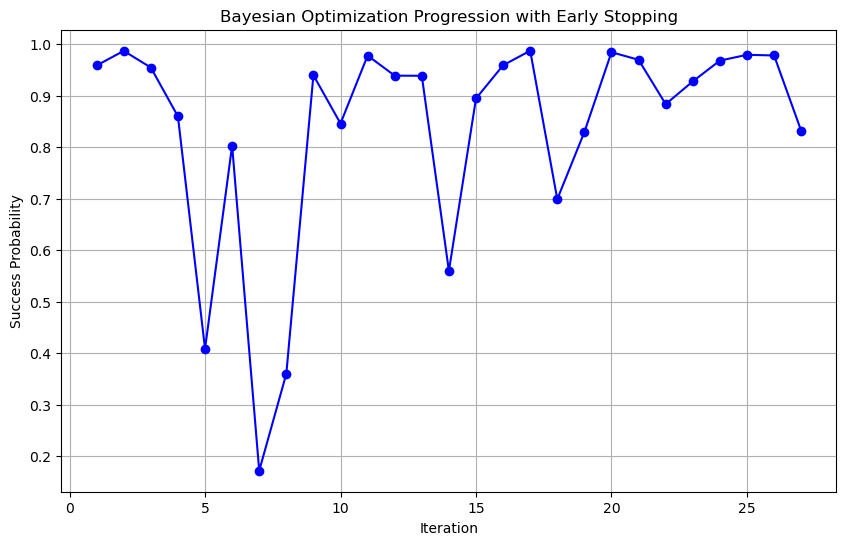

Pipeline and assets loaded from ../../data/model/pipeline/preprocessing_assets.pkl
Loaded asset keys: ['fitted_pipelines', 'feature_indices', 'flattened_feature_indices', 'feature_name_to_index', 'label_encoder']
[Debug] Key: fitted_pipelines, Type: <class 'dict'>
[Debug] Sample from fitted_pipelines: ['numerical_scaler', 'numerical_minmax']
[Debug] Key: feature_indices, Type: <class 'dict'>
[Debug] Sample from feature_indices: ['numerical_scaler', 'numerical_minmax']
[Debug] Key: flattened_feature_indices, Type: <class 'dict'>
[Debug] Sample from flattened_feature_indices: [0, 1, 2, 3, 4]
[Debug] Key: feature_name_to_index, Type: <class 'dict'>
[Debug] Sample from feature_name_to_index: ['release_ball_direction_z', 'release_ball_velocity_z', 'knee_max_angle', 'wrist_release_angle', 'wrist_max_angle']
[Debug] Key: label_encoder, Type: <class 'sklearn.preprocessing._label.LabelEncoder'>
[Debug] Inverse-transformed parameters:    release_ball_direction_x  release_ball_direction_z  \
0   

In [31]:
#%%writefile ../../src/freethrow_predictions/ml/bayes_optim_angles_xgboostpreds.py
import os
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from joblib import load
import matplotlib.pyplot as plt
import pickle  # Added import


def log_debug(message, debug):
    """
    Log debug messages if debug mode is enabled.
    """
    if debug:
        print(message)



def preprocess_data(data_processor, debug):
    """
    Preprocess data and return the transformed data and optimization ranges.
    """
    results = data_processor.run(return_optimization_ranges=True)
    # example usage: X_transformed, y_encoded, transformed_data, transformed_data_df, original_data, X, y, optimization_ranges, optimization_transformed_ranges
    (X_transformed, _, _, _, _, _, _, optimization_ranges, optimization_transformed_ranges) = results

    log_debug(f"[Debug] Data preprocessing completed. Shape: {X_transformed.shape}", debug)
    log_debug(f"[Debug] Optimization Ranges: {optimization_ranges}", debug)
    log_debug(f"[Debug] Optimization Transformed Ranges: {optimization_transformed_ranges}", debug)

    # Return all relevant data
    return X_transformed, optimization_transformed_ranges, optimization_ranges


def define_search_space(transformed_ranges, optimization_columns, debug):
    """
    Define the search space for Bayesian optimization based on transformed ranges.
    """
    # Validate that all optimization_columns are present in transformed_ranges
    missing_columns = [col for col in optimization_columns if col not in transformed_ranges]
    if missing_columns:
        error_msg = f"The following optimization columns are missing in transformed_ranges: {missing_columns}"
        log_debug(f"[Error] {error_msg}", debug)
        raise KeyError(error_msg)

    search_space = [
        Real(transformed_ranges[col][0], transformed_ranges[col][1], name=col)
        for col in optimization_columns
    ]
    log_debug(f"[Debug] Search space defined for columns: {optimization_columns}", debug)
    return search_space


def calculate_baselines(data, columns, debug):
    """
    Calculate baseline values for the optimization columns.
    """
    baselines = data.mean(axis=0).loc[columns].to_dict()
    log_debug(f"[Debug] Baseline Values (Transformed Space): {baselines}", debug)
    return baselines


def objective(params, optimization_columns, X_transformed, model, debug):
    """
    Objective function for Bayesian optimization. Calculates the success probability.
    """
    param_dict = dict(zip(optimization_columns, params))
    feature_vector = pd.Series(X_transformed.mean(axis=0), index=X_transformed.columns)

    for col, value in param_dict.items():
        feature_vector[col] = value

    feature_vector = pd.DataFrame([feature_vector])
    success_prob = model.predict_proba(feature_vector)[0, 1]

    log_debug(f"[Debug] Success probability: {success_prob:.4f}", debug)
    return -success_prob


def perform_optimization(objective_function, search_space, n_calls, debug):
    """
    Perform Bayesian optimization to find the optimal parameters.
    """
    log_debug("[Debug] Starting Bayesian optimization...", debug)
    result = gp_minimize(func=objective_function, dimensions=search_space, n_calls=n_calls, random_state=42)
    log_debug("[Debug] Bayesian optimization completed.", debug)
    log_debug(f"[Debug] Evaluated Parameters: {result.x_iters}", debug)
    log_debug(f"[Debug] Evaluated Success Probabilities: {[-val for val in result.func_vals]}", debug)

    if debug:
        # Visualization of Success Probabilities Over Iterations
        iterations = range(1, len(result.func_vals) + 1)
        success_probabilities = [-val for val in result.func_vals]

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, success_probabilities, marker='o', linestyle='-', color='b')
        plt.title("Bayesian Optimization Progression")
        plt.xlabel("Iteration")
        plt.ylabel("Success Probability")
        plt.grid(True)
        plt.show()

    return result


def inverse_transform_params(preprocessor, params, columns, debug):
    """
    Inverse transform optimization parameters and return them.
    """
    inverse_transformed = preprocessor.inverse_transform_optimization_params(
        params=params, optimization_columns=columns
    )
    log_debug(f"[Debug] Inverse-transformed parameters: {inverse_transformed.head()}", debug)
    return inverse_transformed


def compare_results(
    optimization_columns,
    baselines,
    inverse_baselines,
    final_results,
    res,
    inverse_transformed_params,
    optimization_ranges,
    model,
    X_transformed,
    debug,
):
    """
    Generate a comparison table between baseline, optimized parameters, success probabilities, and original ranges.

    Args:
        optimization_columns (list): List of parameter names.
        baselines (dict): Baseline values for the optimization columns.
        inverse_baselines (pd.DataFrame): Baseline values in the original scale.
        final_results (pd.DataFrame): Final results from the optimization process.
        res (OptimizeResult): Optimization result object.
        inverse_transformed_params (pd.DataFrame): Inverse-transformed parameters.
        optimization_ranges (dict): Original optimization ranges.
        model (object): Trained model to calculate probabilities.
        X_transformed (pd.DataFrame): Transformed feature space.
        debug (bool): Enable debug logging.

    Returns:
        pd.DataFrame: Final comparison table.
    """
    try:
        idx_optimal = res.x_iters.index(res.x)
    except ValueError:
        log_debug("[Error] Optimal parameters not found in x_iters.", debug)
        raise

    original_ranges = pd.DataFrame.from_dict(
        optimization_ranges, orient="index", columns=["Original Min Range", "Original Max Range"]
    ).reset_index().rename(columns={"index": "Parameter"})

    # Create feature vectors for baseline and optimized
    baseline_vector = X_transformed.mean(axis=0)
    optimized_vector = baseline_vector.copy()
    for i, col in enumerate(optimization_columns):
        optimized_vector[col] = res.x[i]

    # Calculate success probabilities
    baseline_vector_df = pd.DataFrame([baseline_vector], columns=X_transformed.columns)
    optimized_vector_df = pd.DataFrame([optimized_vector], columns=X_transformed.columns)
    baseline_success_prob = model.predict_proba(baseline_vector_df)[0, 1]
    optimized_success_prob = model.predict_proba(optimized_vector_df)[0, 1]

    comparison = pd.DataFrame({
        "Parameter": optimization_columns,
        "Baseline (Metric)": inverse_baselines.iloc[0].values,
        "Optimized (Metric)": inverse_transformed_params.iloc[idx_optimal].values,
        "Difference": inverse_transformed_params.iloc[idx_optimal].values - inverse_baselines.iloc[0].values,
        "Baseline Success Probability": [baseline_success_prob] * len(optimization_columns),
        "Optimized Success Probability": [optimized_success_prob] * len(optimization_columns),
    })

    # Merge original ranges into the comparison table
    comparison = comparison.merge(original_ranges, on="Parameter", how="left")

    log_debug("\nComparison of Starting and Optimized Parameters with Success Probabilities:", debug)
    log_debug(comparison, debug)
    return comparison


def perform_bayesian_call_optimization(objective_function, search_space, min_calls, max_calls, repeat_threshold, debug):
    """
    Perform Bayesian optimization with early stopping based on repeated max values or lack of improvement.

    Args:
        objective_function (callable): Function to optimize.
        search_space (list): List of parameter ranges to explore.
        min_calls (int): Minimum number of optimization calls before allowing early stopping.
        max_calls (int): Maximum number of optimization calls.
        repeat_threshold (int): Number of repeats of the max value before stopping.
        debug (bool): Enable debugging and visualization if True.

    Returns:
        skopt.OptimizeResult: Result object containing optimization details.
    """
    log_debug("[Debug] Starting Bayesian optimization with max tracking and early stopping...", debug)

    # Initialize tracking variables
    seen_values = {}
    iteration_results = []
    max_value = float('-inf')  # Start with a very low max value
    max_repeats = 0  # Counter for repeated max values
    iterations_since_max = 0  # Counter for iterations since last new max

    def early_stopping_callback(res):
        nonlocal iteration_results, seen_values, max_value, max_repeats, iterations_since_max
        success_prob = -res.func_vals[-1]  # Current success probability
        iteration_results.append(success_prob)

        # Track occurrences of success_prob
        seen_values[success_prob] = seen_values.get(success_prob, 0) + 1

        # Update max value and repetitions
        if success_prob > max_value:
            max_value = success_prob  # Update max value
            max_repeats = 1  # Reset repeats for the new max
            iterations_since_max = 0  # Reset since we've found a new max
            log_debug(f"[Debug] New max success probability found: {max_value:.4f}", debug)
        elif success_prob == max_value:
            max_repeats = seen_values[success_prob]  # Use total occurrences, not consecutive
            log_debug(f"[Debug] Max success probability {max_value:.4f} repeated {max_repeats} times.", debug)
        else:
            iterations_since_max += 1  # Increment counter for lack of improvement

        # Early stopping conditions
        if len(iteration_results) > min_calls:
            if max_repeats >= repeat_threshold:
                log_debug(f"[Debug] Early stopping triggered. Max value {max_value:.4f} repeated {max_repeats} times.", debug)
                return True  # Trigger early stopping
            if iterations_since_max >= 10:
                log_debug(f"[Debug] Early stopping triggered. No new max found in the last {iterations_since_max} iterations.", debug)
                return True  # Trigger early stopping

        log_debug(f"[Debug] Iteration {len(iteration_results)}, Success Probability: {success_prob:.4f}", debug)
        return False  # Continue optimization

    # Perform Bayesian optimization
    res = gp_minimize(
        func=objective_function,
        dimensions=search_space,
        n_calls=max_calls,
        random_state=42,
        callback=[early_stopping_callback]
    )

    # Visualization of Success Probabilities
    if debug:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(iteration_results) + 1), iteration_results, marker='o', linestyle='-', color='b')
        plt.title("Bayesian Optimization Progression with Early Stopping")
        plt.xlabel("Iteration")
        plt.ylabel("Success Probability")
        plt.grid(True)
        plt.show()

    return res


def save_comparison_table(comparison, save_path, debug):
    """
    Save the comparison table to a CSV file.

    Args:
        comparison (pd.DataFrame): Comparison data to save.
        save_path (str): Path to save the CSV file.
        debug (bool): Enable debug logging.
    """
    try:
        comparison.to_csv(save_path, index=False)
        log_debug(f"[Debug] Comparison table saved to {save_path}", debug)
    except Exception as e:
        log_debug(f"[Error] Failed to save comparison table: {e}", debug)


def bayesian_optimized_metrics_main(
    features_path, dataset_path, assets_path, 
    model_save_dir, comparison_save_path, model_name, y_variable,
    min_calls=20, max_calls=30, repeat_threshold=3, debug=False
):
    log_debug("[Debug] Starting main workflow...", debug)

    # Load selected feature columns from the .pkl file
    try:
        with open(features_path, 'rb') as f:
            selected_features = pickle.load(f)
        if isinstance(selected_features, pd.DataFrame):
            optimization_columns = selected_features.columns.tolist()
        elif isinstance(selected_features, list):
            optimization_columns = selected_features
        else:
            raise ValueError("Unsupported format for selected_features. Expected DataFrame or list.")
        log_debug(f"[Debug] Loaded optimization columns: {optimization_columns}", debug)
        
        # Exclude y_variable from optimization_columns if present
        if y_variable in optimization_columns:
            optimization_columns.remove(y_variable)
            log_debug(f"[Debug] Excluded '{y_variable}' from optimization columns.", debug)
    except Exception as e:
        log_debug(f"[Error] Failed to load optimization columns from {features_path}: {e}", debug)
        raise

    # Initialize data processor and preprocessor
    dp = DataPreprocessor(
        features_path=features_path,
        dataset_path=dataset_path,
        assets_path=assets_path,
        y_variable=y_variable,  # Pass the y_variable here
        optimization_columns=optimization_columns,
        preprocessor_train_test_split=False,
    )

    # Preprocess data
    X_transformed, optimization_transformed_ranges, optimization_ranges = preprocess_data(dp, debug)
    clf = load_model(model_name, save_dir=model_save_dir)

    if not hasattr(clf, 'predict_proba'):
        raise AttributeError(f"The model '{model_name}' does not support 'predict_proba'.")

    # Define the search space
    search_space = define_search_space(optimization_transformed_ranges, optimization_columns, debug)

    # Define the wrapped objective function
    def wrapped_objective(params):
        return objective(params, optimization_columns, X_transformed, clf, debug)

    # Perform optimization
    res = perform_bayesian_call_optimization(
        wrapped_objective,
        search_space,
        min_calls=min_calls,
        max_calls=max_calls,
        repeat_threshold=repeat_threshold,
        debug=debug
    )

    # Post-process results
    params_df = pd.DataFrame(res.x_iters, columns=optimization_columns)
    params_df['success_prob'] = -res.func_vals

    inverse_preprocessor = InversePreprocessor(assets_path=assets_path, debug=debug)
    inverse_transformed_params = inverse_transform_params(
        inverse_preprocessor, params_df[optimization_columns], optimization_columns, debug
    )

    baseline_df = pd.DataFrame([calculate_baselines(X_transformed, optimization_columns, debug)])
    inverse_baselines = inverse_transform_params(
        inverse_preprocessor, baseline_df, optimization_columns, debug
    )

    final_results = pd.concat(
        [inverse_transformed_params.reset_index(drop=True),
         params_df[['success_prob']].reset_index(drop=True)],
        axis=1
    )
    comparison = compare_results(
        optimization_columns,
        baseline_df,
        inverse_baselines,
        final_results,
        res,
        inverse_transformed_params,
        optimization_ranges,
        clf,  # Pass the trained model
        X_transformed,  # Pass the transformed feature space
        debug,
    )

    # Save the comparison table
    save_comparison_table(comparison, comparison_save_path, debug)

    if not debug:
        print("Comparison of Starting and Optimized Parameters:")
        print(comparison)


if __name__ == "__main__":
    bayesian_optimized_metrics_main(
        features_path='../../data/model/pipeline/final_ml_df_selected_features_columns.pkl',
        dataset_path='../../data/processed/final_ml_dataset.csv',
        assets_path='../../data/model/pipeline/preprocessing_assets.pkl',
        model_save_dir='../../data/model',
        comparison_save_path='../../data/model/bayesian_optimized_metrics/bayesian_optimized_metrics_comparison_table.csv',
        model_name='XGBoost',
        y_variable='result',  # Specify your target variable here to filter out of the final_ml_df_selected_features_columns
        min_calls=20,  # it finds the optimized amount of calls by looking for if the max is repeated after the min amount of calls
        max_calls=100,
        repeat_threshold=3,
        debug=True
    )
